**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/BVT.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date  Open  High   Low  Close  Volume  Earnings Yield (EY)  \
0 1999-01-01  1198  1199  1197   1198       0               15.327   
1 1999-01-04  1178  1178  1163   1164  181317               16.039   
2 1999-01-05  1164  1170  1162   1166  313064               16.039   
3 1999-01-06  1170  1257  1170   1234  590466               14.970   
4 1999-01-07  1255  1282  1255   1268  305378               14.614   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0             1.069296         6.524434      -           -   
1             1.069296         6.234803      -           -   
2             1.069296         6.234803      -           -   
3             1.069296         6.680027      -           -   
4             1.069296         6.842754      -           -   

   Total Return Index (TRI)  
0                578.406132  
1                561.990599  
2                562.956219  
3                595.787285  
4                612.202818

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11 -0.050535 -0.014302  0.010671  0.023783  0.033928  0.030795   
2000-05-12 -0.055880  0.007012 -0.023783 -0.013112  0.000000  0.010144   
2000-05-15 -0.073623 -0.005505 -0.015650 -0.039433 -0.028762 -0.015650   
2000-05-16 -0.062010 -0.018809 -0.003160 -0.018809 -0.042593 -0.031922   
2000-05-17 -0.055344 -0.032713 -0.000791 -0.003951 -0.019601 -0.043384   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11 -0.057862 -0.039364 -0.038070  -0.032844  ...     -0.031677   
2000-05-12 -0.037953 -0.023906 -0.042486  -0.025598  ...     -0.014302   
2000-05-15 -0.019920 -0.017772 -0.048155  -0.021945  ...      0.007012   
2000-05-16 -0.012656 -0.018118 -0.045792  -0.021375  ...     -0.005505   
2000-05-17 -0.012864 -0.022983 -0.041833  -0.023436  ...     -0.018809   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11    -0.032015     -0.003713          -0.002230          0.008218   
2000-05-12     0.025218     -0.003744          -0.003744          0.061891   
2000-05-15     0.002369     -0.016937           0.007012          0.018019   
2000-05-16     0.000000     -0.009339           0.003132          0.012589   
2000-05-17    -0.019740     -0.052279          -0.016439         -0.009427   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11            0.004474           -0.021006          -0.010558   
2000-05-12            0.041354           -0.038085           0.027550   
2000-05-15            0.010144           -0.008638           0.002369   
2000-05-16           -0.007012           -0.008665           0.000791   
2000-05-17           -0.029551           -0.019601          -0.012589   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11           -0.022490         -0.021229  
2000-05-12           -0.038085          0.051333  
2000-05-15           -0.032586          0.018019  
2000-05-16           -0.021136          0.003951  
2000-05-17           -0.055441         -0.011797  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.007602556503302251
  dropout = 0.18418674341703709
  units = 192
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 249
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0012175155752659364
RMSE = 0.03489291583209888
MAE = 0.027363853294949017
R-Squared = -0.1107927669956863

Results on Validation set: 
MSE = 0.0011313682467833125
RMSE = 0.033635817914587904
MAE = 0.026373283896707143
R-Squared = 0.010181414208667472

Results on Testing set: 
MSE = 0.0008670870164119095
RMSE = 0.029446341307739904
MAE = 0.02378070753927668
R-Squared = -0.19327479469549047



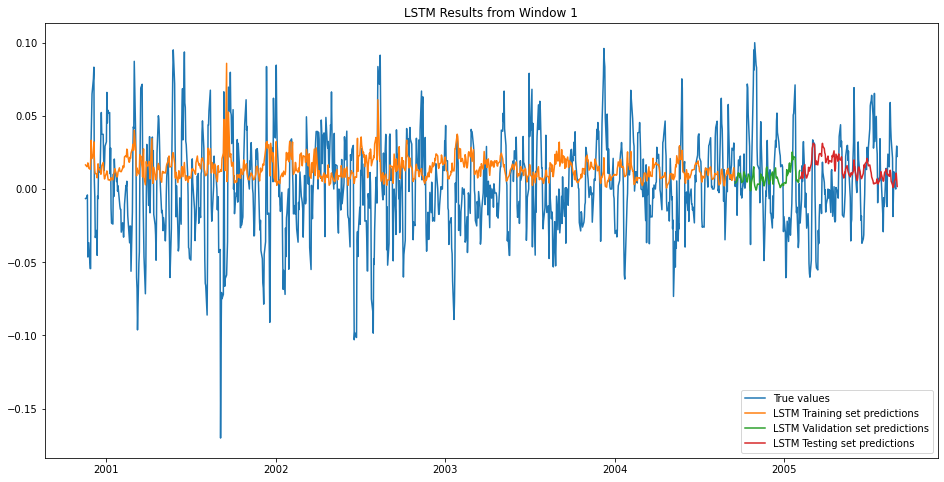

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0014317373562424067
RMSE = 0.037838305409233206
MAE = 0.029847232060249803
R-Squared = -0.3619125293585619

Results on Validation set: 
MSE = 0.0006176361120112677
RMSE = 0.02485228585082804
MAE = 0.02034346156671369
R-Squared = 0.035284871221733405

Results on Testing set: 
MSE = 0.001174795942032828
RMSE = 0.034275296381400235
MAE = 0.027166816168738978
R-Squared = -0.22815641890308336



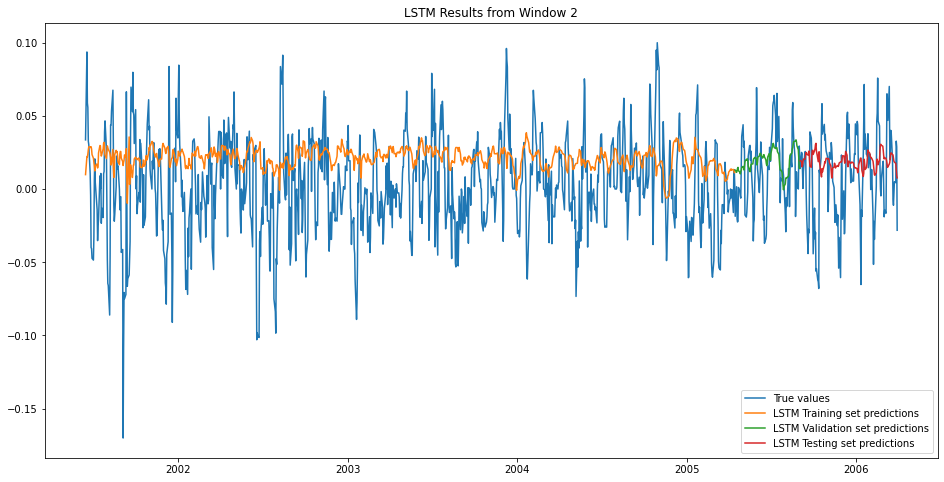

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0009348051848278743
RMSE = 0.030574583968189562
MAE = 0.02369058157683377
R-Squared = -0.03239994452875772

Results on Validation set: 
MSE = 0.0008556626474262806
RMSE = 0.029251711871722662
MAE = 0.023887961323395972
R-Squared = 0.05580722003007332

Results on Testing set: 
MSE = 0.001561356536218624
RMSE = 0.03951400430503879
MAE = 0.03079957280730121
R-Squared = -0.13706395833620455



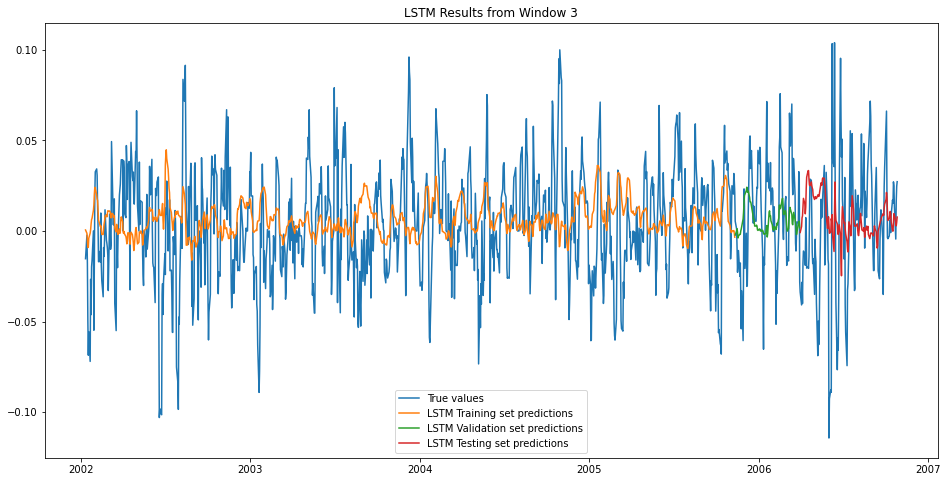

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0008925693230920977
RMSE = 0.029875898699321127
MAE = 0.02329833712216044
R-Squared = 0.012687981617794719

Results on Validation set: 
MSE = 0.0009900447598191174
RMSE = 0.0314649767172823
MAE = 0.024063929030127662
R-Squared = 0.121189092486368

Results on Testing set: 
MSE = 0.0007953889397374146
RMSE = 0.028202640651850575
MAE = 0.022913573735187712
R-Squared = -0.04316012351123799



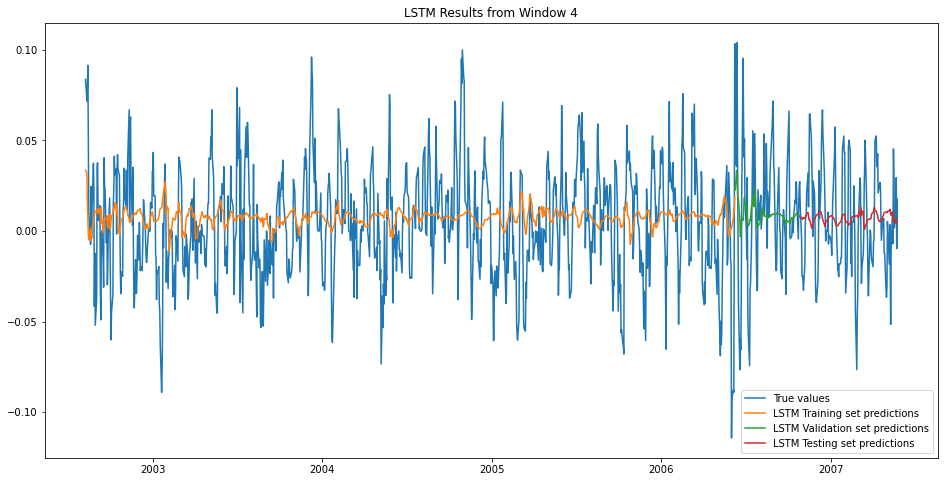

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0008855451594101084
RMSE = 0.02975811081722273
MAE = 0.02310693602511768
R-Squared = 0.025060233521859043

Results on Validation set: 
MSE = 0.0007043995390056227
RMSE = 0.026540526351329634
MAE = 0.021386406124687514
R-Squared = 0.05642081223015771

Results on Testing set: 
MSE = 0.0008944449528776155
RMSE = 0.029907272575037922
MAE = 0.022549626415043662
R-Squared = -0.17284292906466092



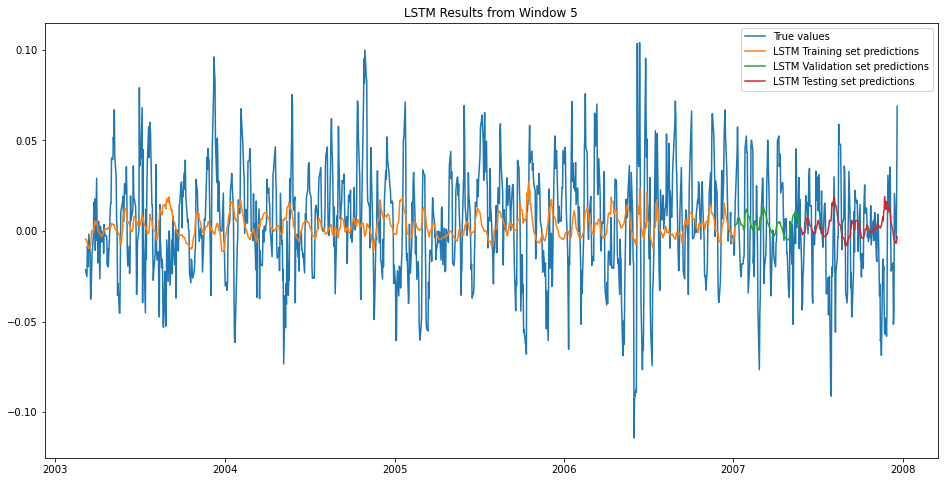

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0011215663804726086
RMSE = 0.03348979516916472
MAE = 0.0263043254010287
R-Squared = -0.21964006170896488

Results on Validation set: 
MSE = 0.0008876668793121557
RMSE = 0.029793738928039156
MAE = 0.022576754869898286
R-Squared = -0.18081571661165596

Results on Testing set: 
MSE = 0.002586009060867757
RMSE = 0.05085281762958427
MAE = 0.04115099867769339
R-Squared = -0.10774914058772311



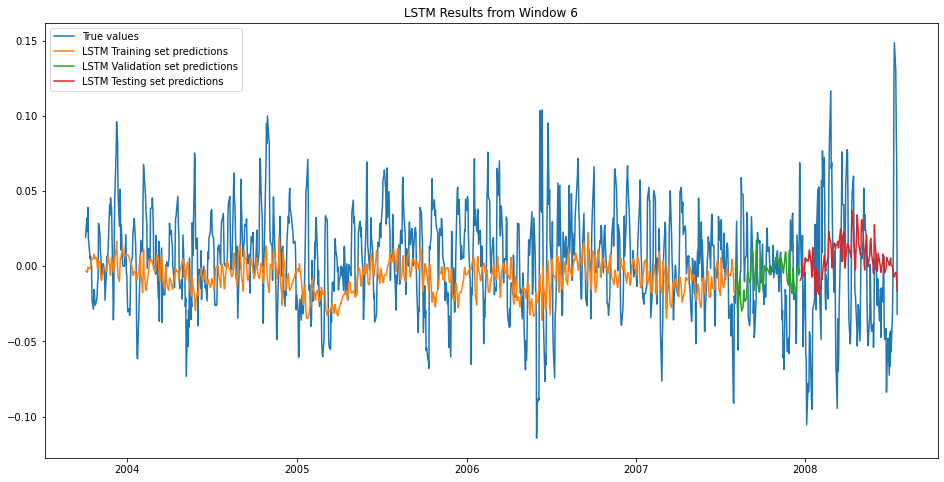

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0010550707178661408
RMSE = 0.03248185213109223
MAE = 0.025055717549140103
R-Squared = -0.018693039971028114

Results on Validation set: 
MSE = 0.0022031243087651665
RMSE = 0.04693745102543561
MAE = 0.03673536854814213
R-Squared = -0.03595827160352405

Results on Testing set: 
MSE = 0.0027708237759029933
RMSE = 0.05263861487447208
MAE = 0.043184781987756396
R-Squared = -0.1825373550448075



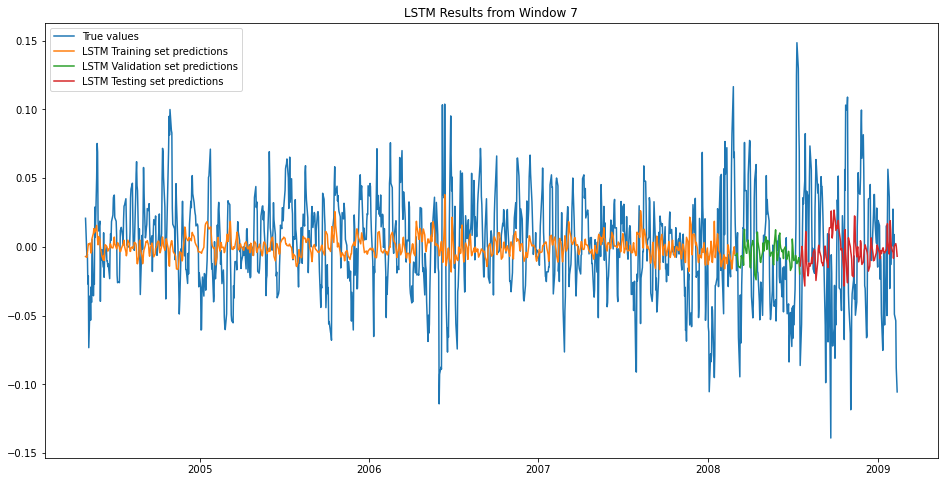

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.001197674304529142
RMSE = 0.034607431348326646
MAE = 0.026747873160195154
R-Squared = 0.02222692764231493

Results on Validation set: 
MSE = 0.002345259557144361
RMSE = 0.04842787995715238
MAE = 0.03836551650522839
R-Squared = 0.007453281349022345

Results on Testing set: 
MSE = 0.0019516423305368875
RMSE = 0.044177396149353204
MAE = 0.03398984394680735
R-Squared = -0.1338569640583791



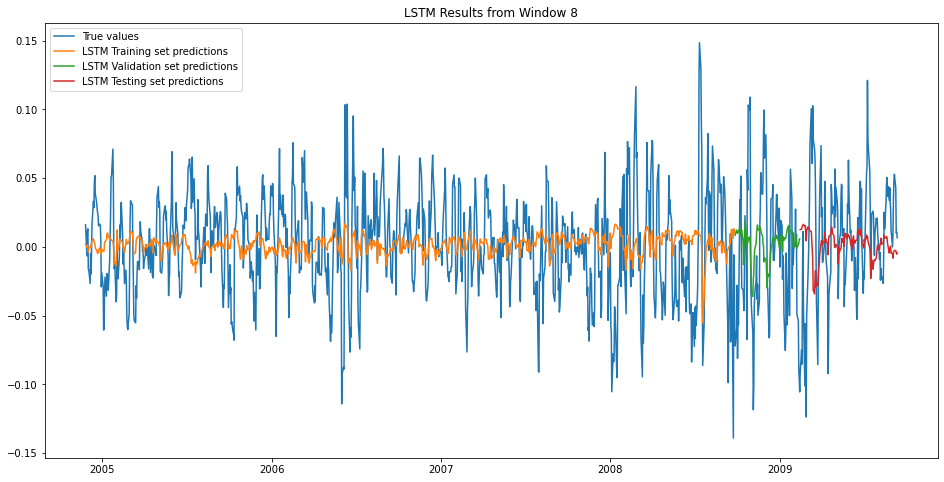

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0014913023909978933
RMSE = 0.03861738456961959
MAE = 0.029447994541874918
R-Squared = 0.016981526608925157

Results on Validation set: 
MSE = 0.0008788567042291161
RMSE = 0.02964551743905166
MAE = 0.02333095140846229
R-Squared = 0.0038276351525511343

Results on Testing set: 
MSE = 0.0006001365803254504
RMSE = 0.024497685203411574
MAE = 0.018696192550119024
R-Squared = -0.006304217668349876



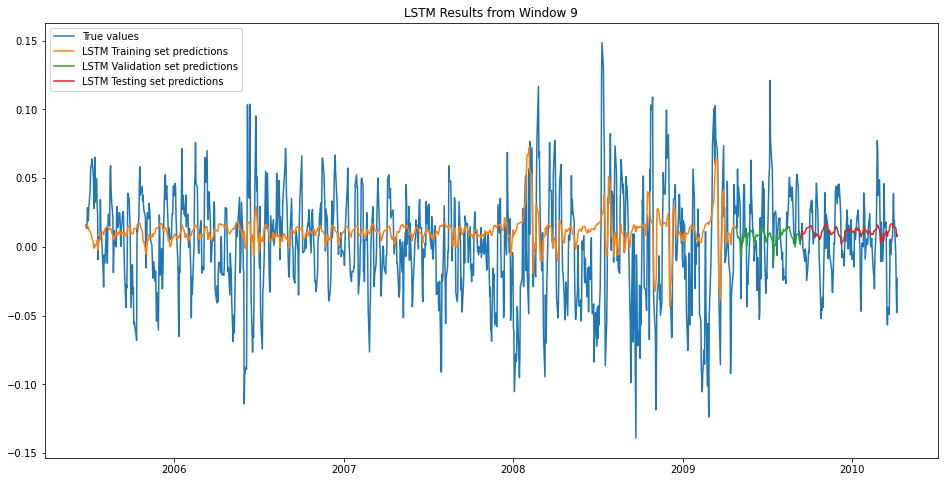

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.001491457248528132
RMSE = 0.03861938954111176
MAE = 0.029463530747678497
R-Squared = 0.004585371290510176

Results on Validation set: 
MSE = 0.0006193195445371376
RMSE = 0.024886131570357368
MAE = 0.01883514948346947
R-Squared = 0.019291671872298077

Results on Testing set: 
MSE = 0.0008617417263799193
RMSE = 0.029355437765087394
MAE = 0.023307879164469438
R-Squared = -0.027827013375972154



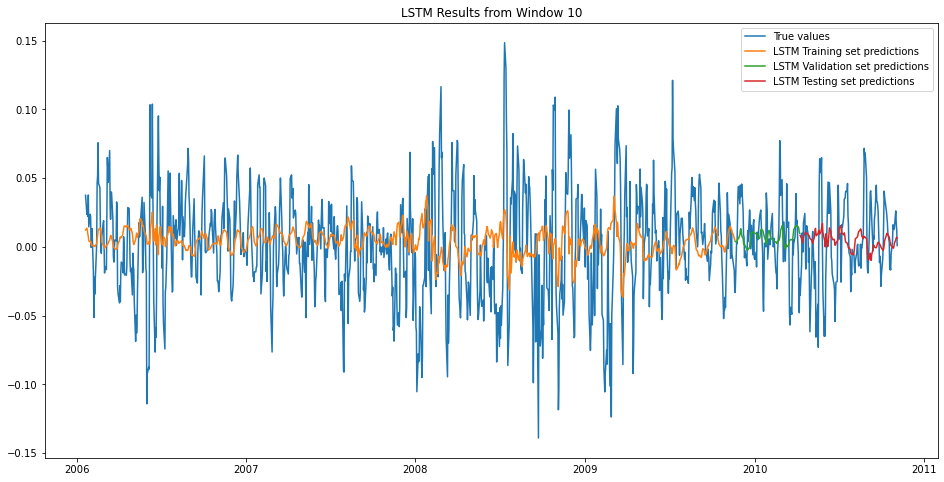

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0012760154177943223
RMSE = 0.035721358006021026
MAE = 0.02705297186713048
R-Squared = 0.09367064283443405

Results on Validation set: 
MSE = 0.0005916207257546631
RMSE = 0.02432325483471863
MAE = 0.019542229413961273
R-Squared = 0.03625241719964378

Results on Testing set: 
MSE = 0.0006229681896665149
RMSE = 0.02495933071351303
MAE = 0.018869817982731244
R-Squared = -0.15316673989971652



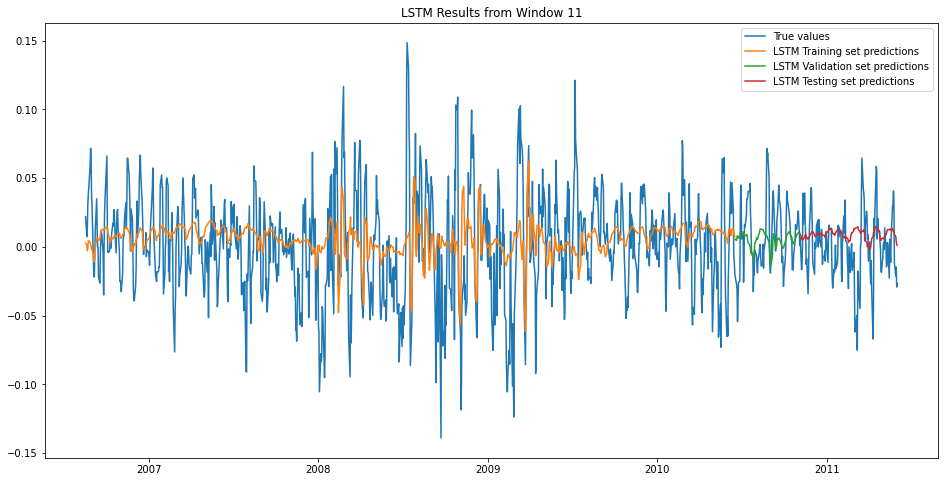

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0014897697606963511
RMSE = 0.038597535681651376
MAE = 0.02959741026267693
R-Squared = -0.09430018755745673

Results on Validation set: 
MSE = 0.0006211601156670466
RMSE = 0.024923083991894877
MAE = 0.018231354959402556
R-Squared = 0.06855618210243941

Results on Testing set: 
MSE = 0.001218485869464258
RMSE = 0.03490681694833057
MAE = 0.027514751920527658
R-Squared = 0.09361799393247672



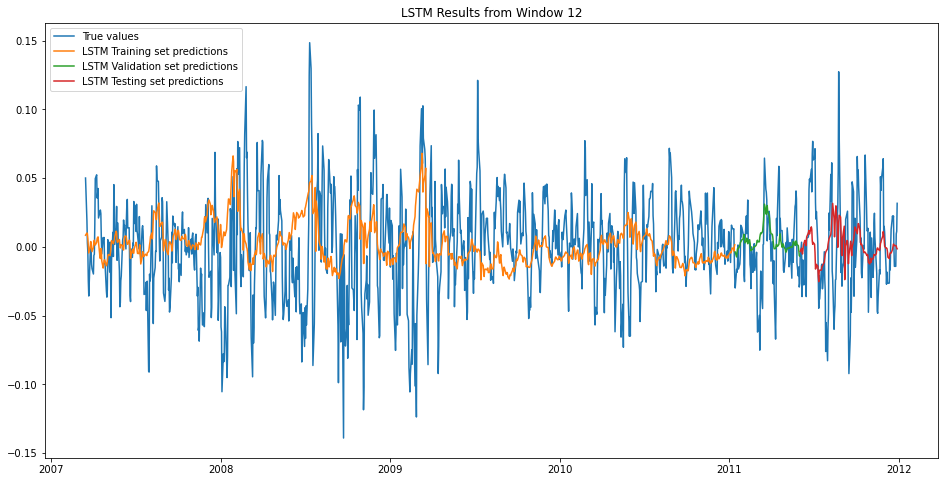

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0014209152953901386
RMSE = 0.037695030115257086
MAE = 0.02839202353936546
R-Squared = -0.011729253118139438

Results on Validation set: 
MSE = 0.001090819385084966
RMSE = 0.033027554936521805
MAE = 0.02533607969819418
R-Squared = 0.1019586971115295

Results on Testing set: 
MSE = 0.000504898543520089
RMSE = 0.022469947563803726
MAE = 0.016992836865553917
R-Squared = -0.03261416591102906



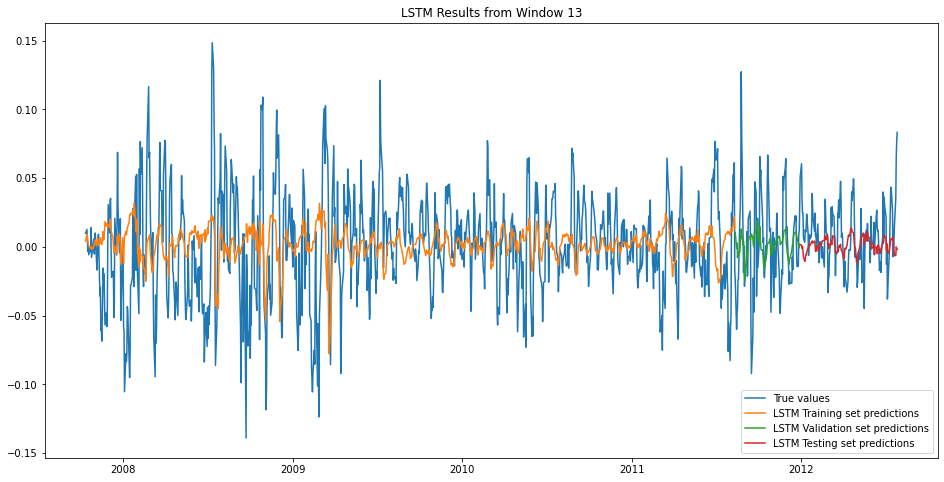

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0014811442965884435
RMSE = 0.038485637536468636
MAE = 0.028168891096732644
R-Squared = -0.15890529511910367

Results on Validation set: 
MSE = 0.0005124279958383348
RMSE = 0.022636872483590458
MAE = 0.017063497541969473
R-Squared = 0.10355779629005402

Results on Testing set: 
MSE = 0.00045400614538176453
RMSE = 0.021307419960702997
MAE = 0.016456333332992255
R-Squared = -0.011693500395953293



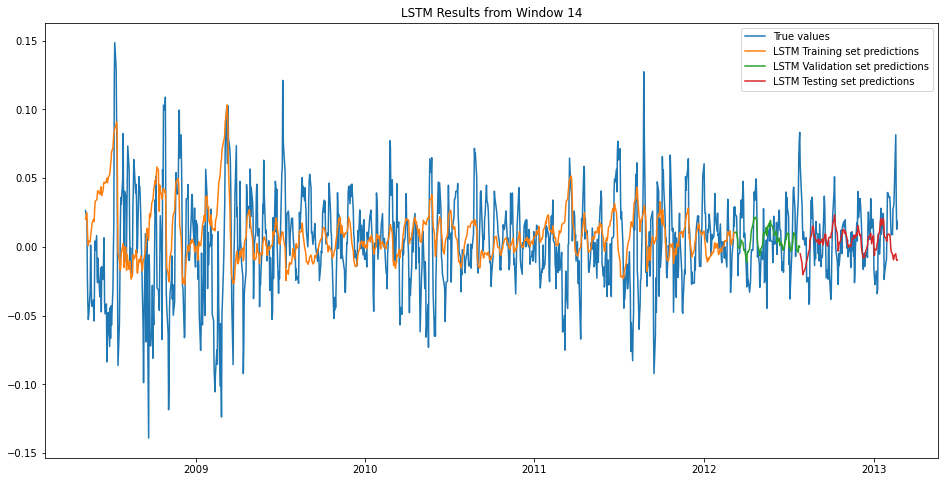

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0009022827479264582
RMSE = 0.030038021704607284
MAE = 0.0221554856267972
R-Squared = 0.04925867786220195

Results on Validation set: 
MSE = 0.00039325259553320903
RMSE = 0.01983059745779761
MAE = 0.015362168594745262
R-Squared = 0.06787812254495951

Results on Testing set: 
MSE = 0.0012130931665519896
RMSE = 0.034829487026828136
MAE = 0.025377643145181636
R-Squared = -0.07167814257515448



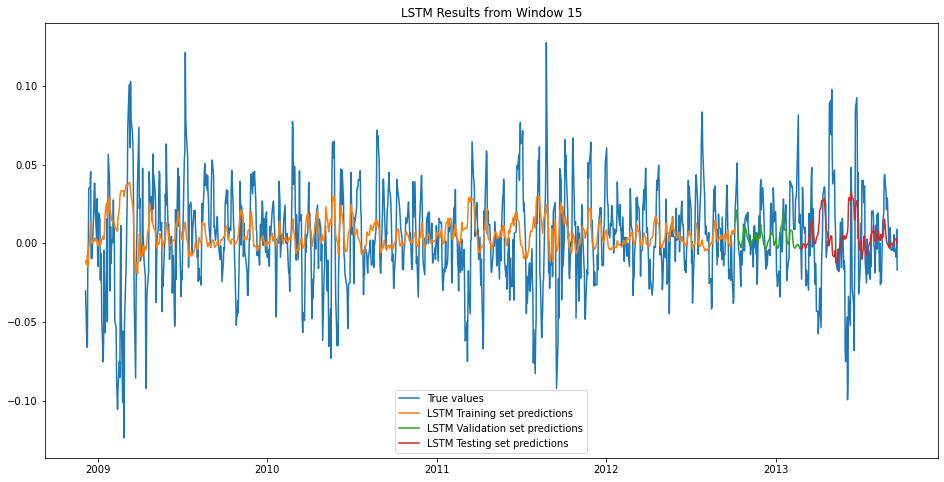

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0007543295504995551
RMSE = 0.027465060540613324
MAE = 0.021249961864693384
R-Squared = 0.018679124199857178

Results on Validation set: 
MSE = 0.0009203165348266616
RMSE = 0.030336719249560617
MAE = 0.02194972314149728
R-Squared = 0.0989734497507111

Results on Testing set: 
MSE = 0.000733205477096515
RMSE = 0.02707776721032432
MAE = 0.021282293714764495
R-Squared = -0.16192053575333265



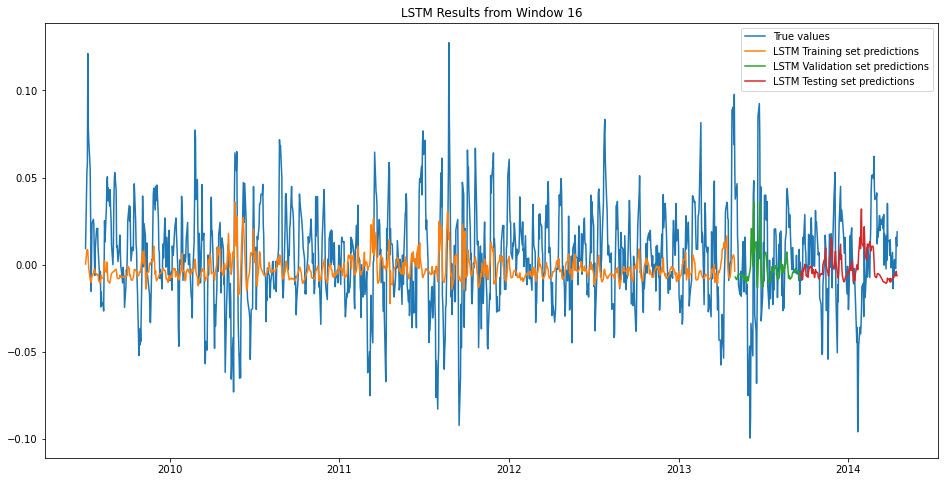

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0007720398907958014
RMSE = 0.027785605820204846
MAE = 0.021124726399178517
R-Squared = 0.01793790611287782

Results on Validation set: 
MSE = 0.0007703239320516544
RMSE = 0.0277547100876888
MAE = 0.020922654040998953
R-Squared = -0.04329130721592245

Results on Testing set: 
MSE = 0.00047991530214319195
RMSE = 0.021906969259648672
MAE = 0.01722710949411552
R-Squared = -0.06311258771513018



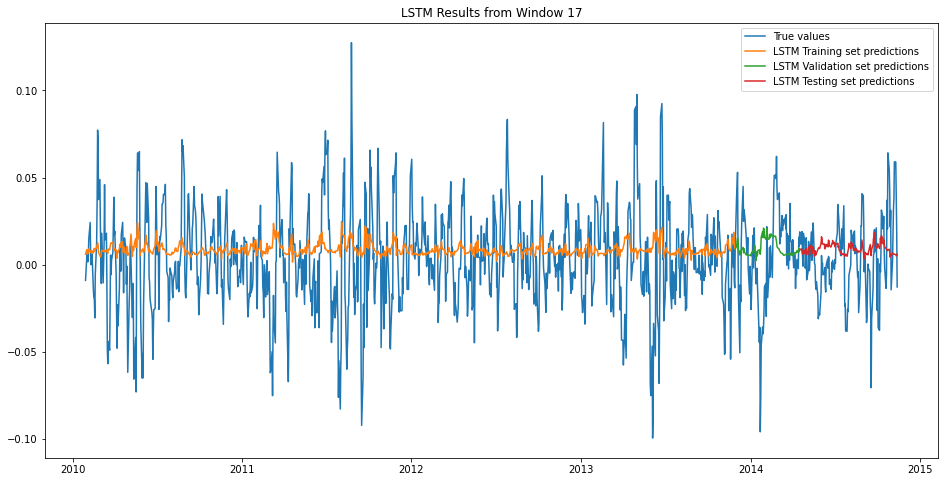

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0007027231711263078
RMSE = 0.026508926253741547
MAE = 0.020013088765476958
R-Squared = 0.03871781617712988

Results on Validation set: 
MSE = 0.000519360235683286
RMSE = 0.02278947642407096
MAE = 0.018011234064205118
R-Squared = 0.09601242692748302

Results on Testing set: 
MSE = 0.0008891681034937915
RMSE = 0.029818921903613342
MAE = 0.022488988418301697
R-Squared = -0.10569800677310526



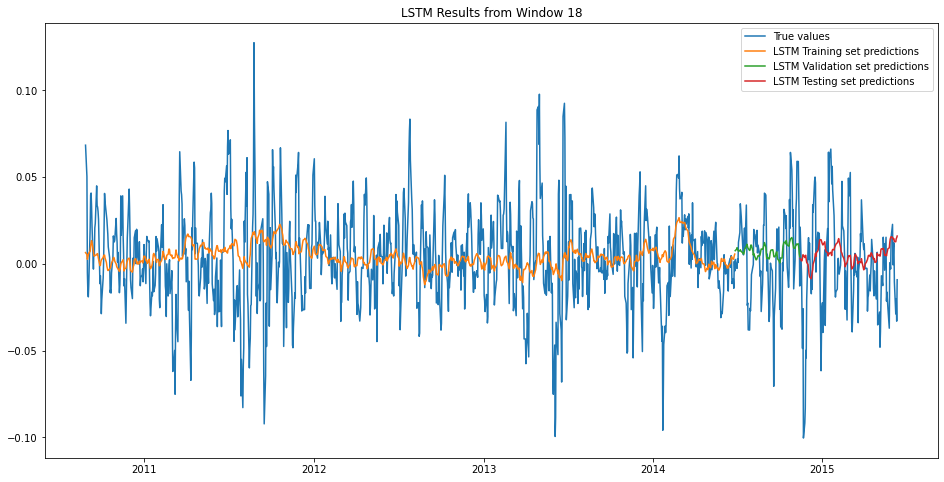

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0007536059530985857
RMSE = 0.027451884326919813
MAE = 0.020554582081565236
R-Squared = 0.041573678069091624

Results on Validation set: 
MSE = 0.00045524280064736684
RMSE = 0.02133641958359853
MAE = 0.01675059359039089
R-Squared = -0.09268006050223843

Results on Testing set: 
MSE = 0.0009260670691428678
RMSE = 0.030431350103846327
MAE = 0.024071105231805643
R-Squared = -0.014026847495093087



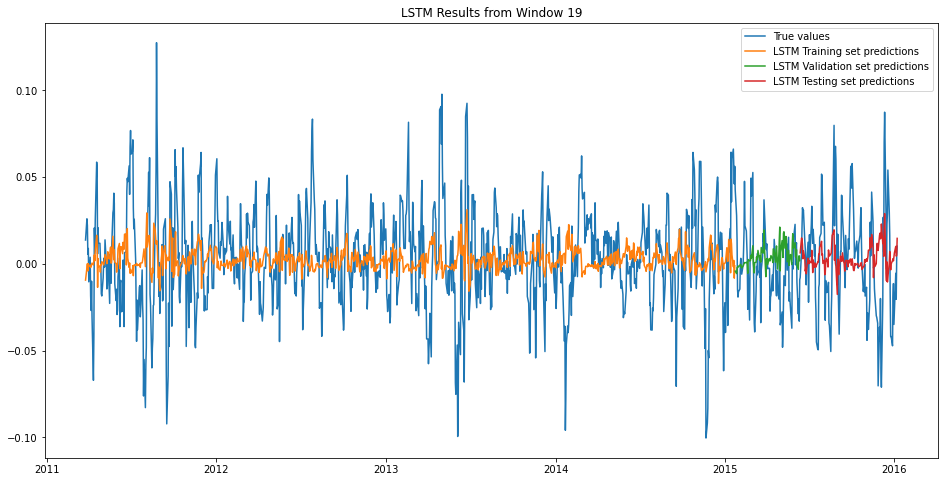

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0006567600576965289
RMSE = 0.025627330288122658
MAE = 0.01927165321770681
R-Squared = 0.026095748597409485

Results on Validation set: 
MSE = 0.0009988999460695904
RMSE = 0.03160537843579144
MAE = 0.024750597483301617
R-Squared = 0.04308376003798031

Results on Testing set: 
MSE = 0.003827994468271206
RMSE = 0.06187078848916673
MAE = 0.04121447496198703
R-Squared = -0.14843586260593322



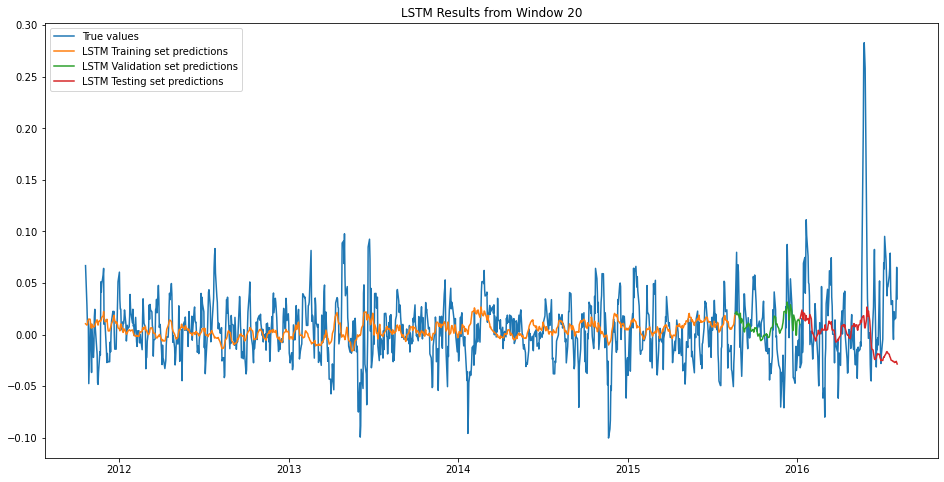

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0007747113713443013
RMSE = 0.027833637407717687
MAE = 0.020723140946507353
R-Squared = 0.013918011049970147

Results on Validation set: 
MSE = 0.004496536843707239
RMSE = 0.06705622151379571
MAE = 0.0391779709341942
R-Squared = -0.09214727960662139

Results on Testing set: 
MSE = 0.0011905356158668453
RMSE = 0.0345041391120956
MAE = 0.02782396271636144
R-Squared = -0.05585982369294862



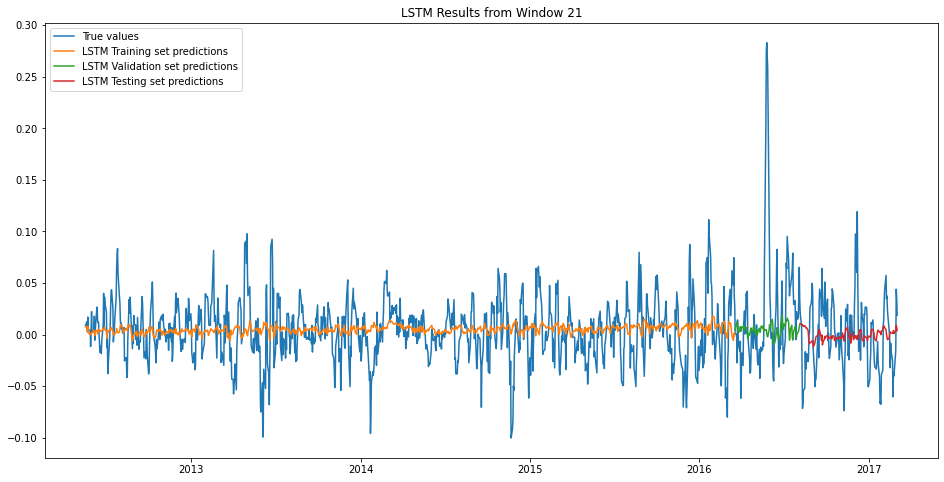

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0012414507286585272
RMSE = 0.03523422666468681
MAE = 0.024148936782242992
R-Squared = -0.017403251925173224

Results on Validation set: 
MSE = 0.001098690822531142
RMSE = 0.03314650543467806
MAE = 0.025749189476456165
R-Squared = 0.014799836169247294

Results on Testing set: 
MSE = 0.0009828699618963492
RMSE = 0.0313507569589053
MAE = 0.025345726088103857
R-Squared = 0.011645518753478745



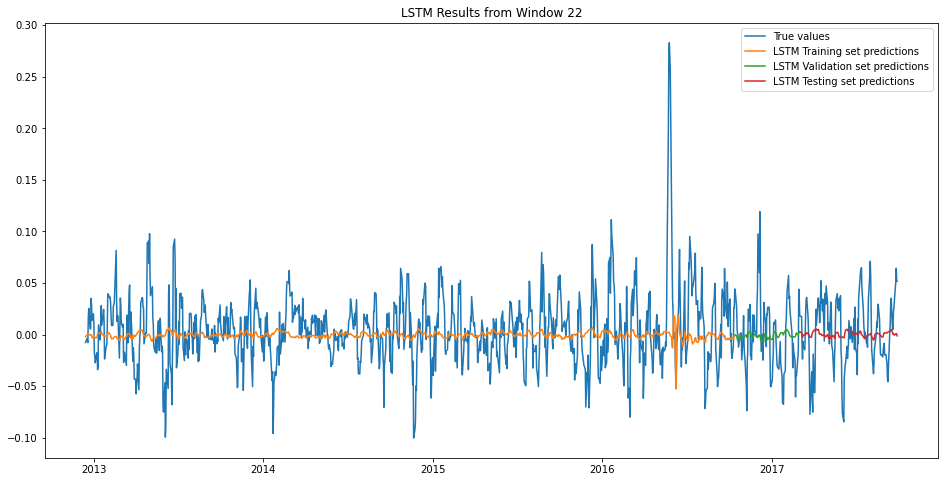

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0012340993691306043
RMSE = 0.035129750484889644
MAE = 0.02418612357325433
R-Squared = -0.026298348585906295

Results on Validation set: 
MSE = 0.0009447302942595445
RMSE = 0.030736465220638897
MAE = 0.024726434338798554
R-Squared = 0.04499217953385437

Results on Testing set: 
MSE = 0.0019376529978369524
RMSE = 0.04401878005848132
MAE = 0.03225575818431653
R-Squared = -0.1473258878197583



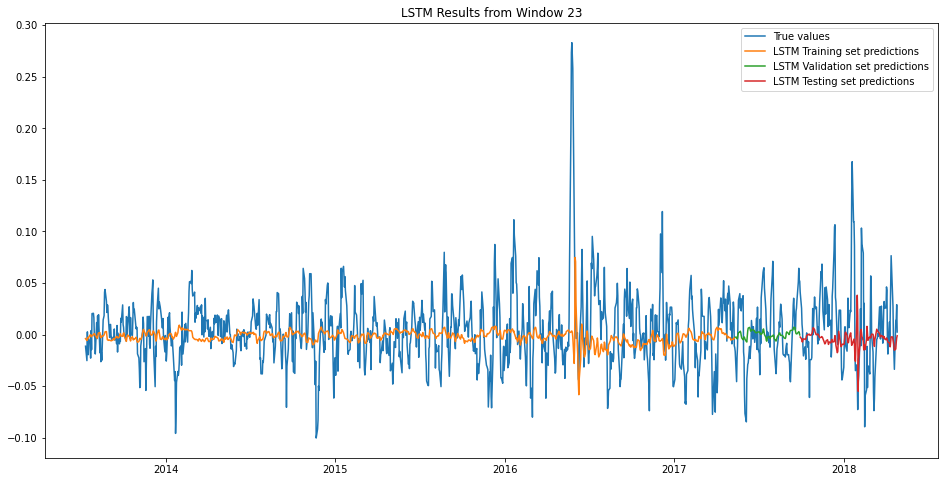

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0012442878840422356
RMSE = 0.03527446504260888
MAE = 0.024885810703887727
R-Squared = 0.0057687237216739184

Results on Validation set: 
MSE = 0.002321116690821444
RMSE = 0.048177968936241426
MAE = 0.03551454885062397
R-Squared = -0.061397251420029386

Results on Testing set: 
MSE = 0.0016504878347908668
RMSE = 0.040626196410578075
MAE = 0.032363294940606316
R-Squared = -0.03253477614981959



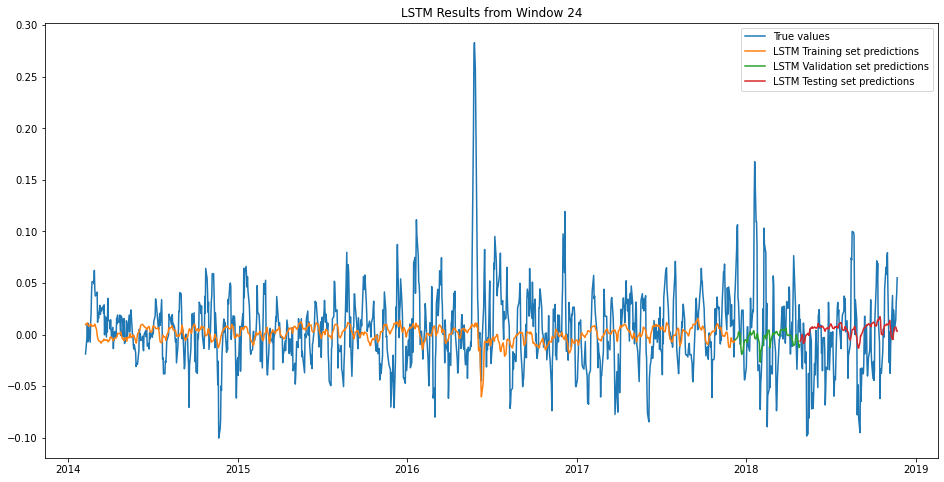

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4982

Results on Training set: 
MSE = 0.0015135237980662278
RMSE = 0.038904033185085424
MAE = 0.02775382526725242
R-Squared = -0.004290556396103762

Results on Validation set: 
MSE = 0.001636193363587866
RMSE = 0.04044988706520534
MAE = 0.0327931812031368
R-Squared = 0.04001492947062624

Results on Testing set: 
MSE = 0.001274418443713377
RMSE = 0.03569899779704434
MAE = 0.028724396499867872
R-Squared = 0.01508047146312097



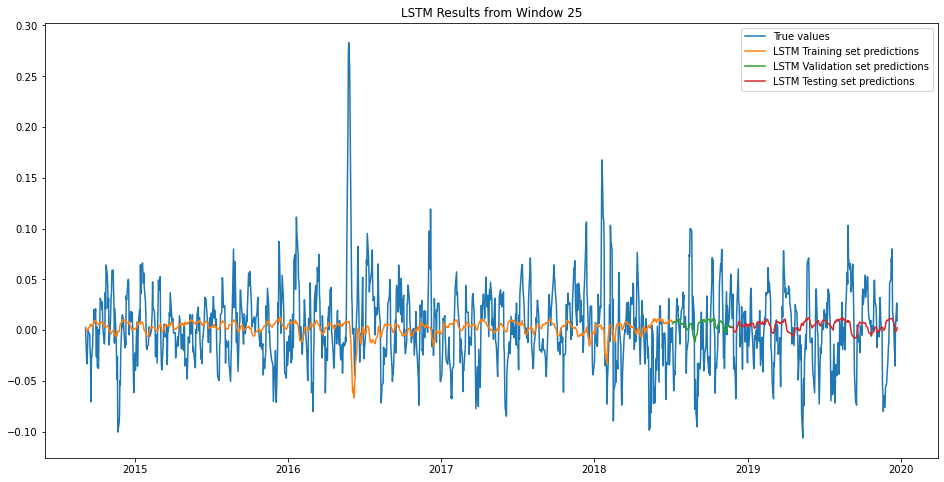

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 136
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.002827388517269168
  dropout = 0.17279149398322147
  units = 209

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 247
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.001411934454416147
RMSE = 0.03757571628613548
MAE = 0.029420878482395357
R-Squared = -0.23707319293972695

Results on Validation set: 
MSE = 0.0010366764583502027
RMSE = 0.032197460433242286
MAE = 0.023291907896029244
R-Squared = -0.04174405833773043

Results on Testing set: 
MSE = 0.0016223771494581713
RMSE = 0.040278743146455936
MAE = 0.03335048928045872
R-Squared = -1.0534422315462804



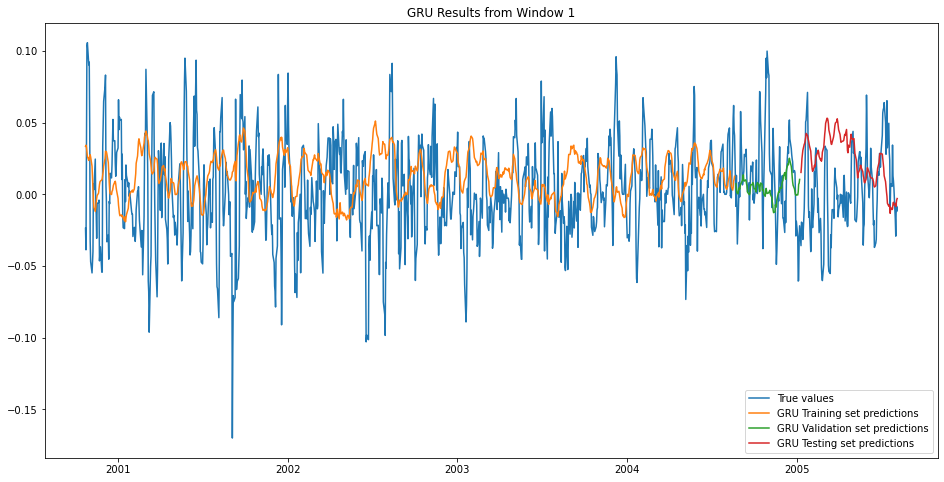

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.000998138505111736
RMSE = 0.031593330073161584
MAE = 0.023899796946536774
R-Squared = 0.08287009307487248

Results on Validation set: 
MSE = 0.0006273600270990371
RMSE = 0.025047156068085597
MAE = 0.01948580164330511
R-Squared = -0.04599161715326994

Results on Testing set: 
MSE = 0.001023860813329521
RMSE = 0.031997825134366886
MAE = 0.02641376373353903
R-Squared = -0.13679985115028304



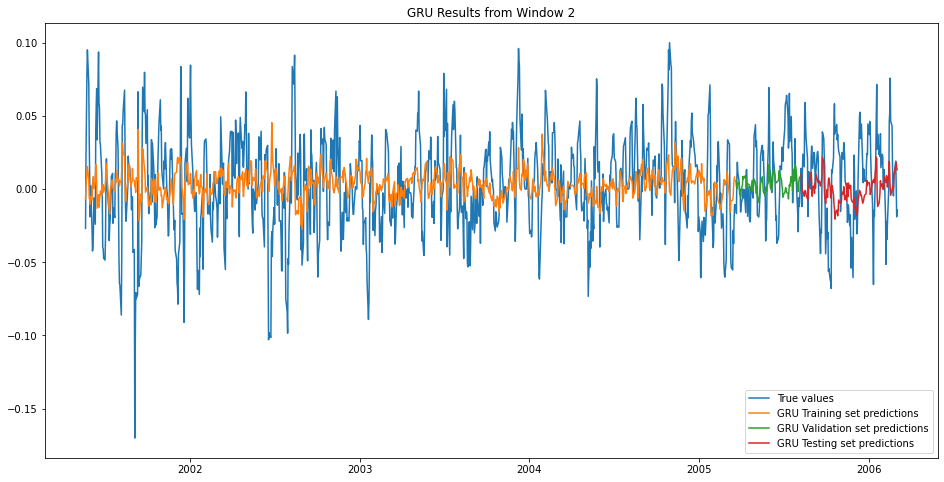

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0009519634157261665
RMSE = 0.030853904383824206
MAE = 0.024036885660868583
R-Squared = -0.02899052311229977

Results on Validation set: 
MSE = 0.0007966839883715597
RMSE = 0.028225591018994797
MAE = 0.023389287166159317
R-Squared = 0.05915431976523111

Results on Testing set: 
MSE = 0.0016037698093879945
RMSE = 0.040047094893237815
MAE = 0.030987328421584717
R-Squared = -0.11063219593047746



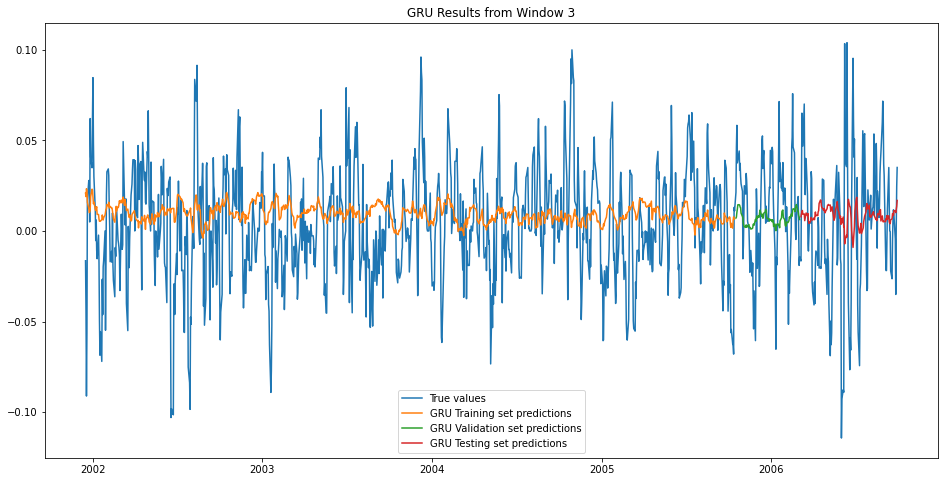

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0008504574147190459
RMSE = 0.029162603016861268
MAE = 0.022768282528663284
R-Squared = 0.047193603540575224

Results on Validation set: 
MSE = 0.0012020609970825223
RMSE = 0.03467075131984483
MAE = 0.02652762737494391
R-Squared = 0.25847242188178454

Results on Testing set: 
MSE = 0.0007694846747049116
RMSE = 0.027739586779635193
MAE = 0.02194740301137338
R-Squared = -0.05060324379539205



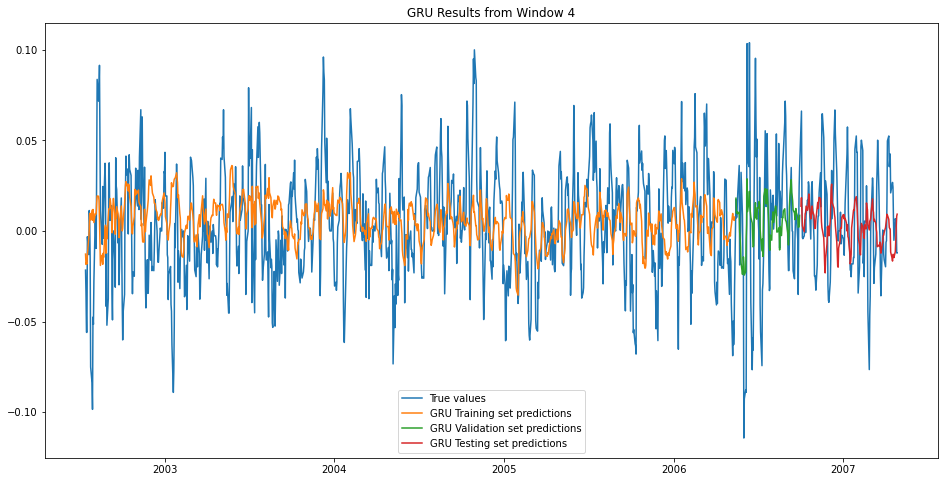

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0007827388462143025
RMSE = 0.02797747033264985
MAE = 0.02169584874496771
R-Squared = 0.1383017876033471

Results on Validation set: 
MSE = 0.00073285382303957
RMSE = 0.027071273022146004
MAE = 0.021629531378083593
R-Squared = 0.029863337034913395

Results on Testing set: 
MSE = 0.0010056183574595706
RMSE = 0.031711486207044455
MAE = 0.023788344592100497
R-Squared = -0.4576985253451251



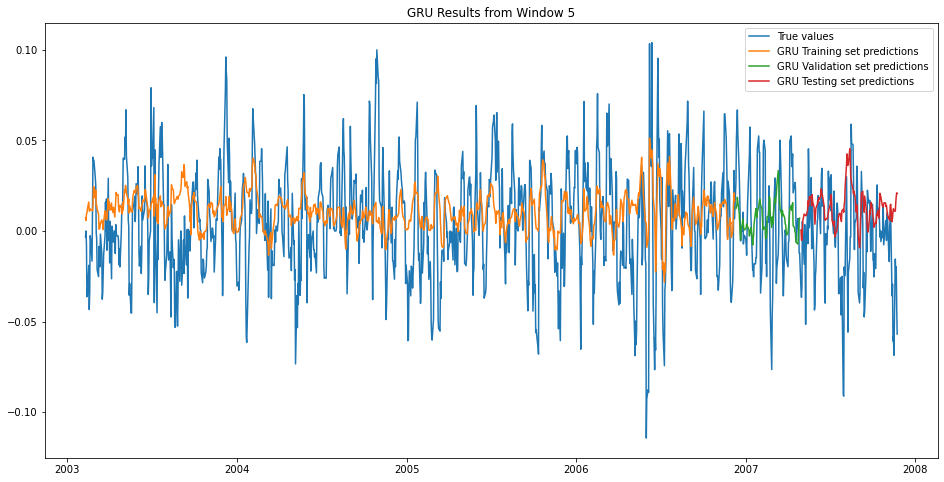

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.001033184413737116
RMSE = 0.0321431861167669
MAE = 0.02522611489770202
R-Squared = -0.1540742076485675

Results on Validation set: 
MSE = 0.0007909663349579213
RMSE = 0.02812412371893427
MAE = 0.021578179094572488
R-Squared = -0.06553065429114002

Results on Testing set: 
MSE = 0.00182008348065726
RMSE = 0.042662436412577984
MAE = 0.03457862079518598
R-Squared = -0.02273906931346059



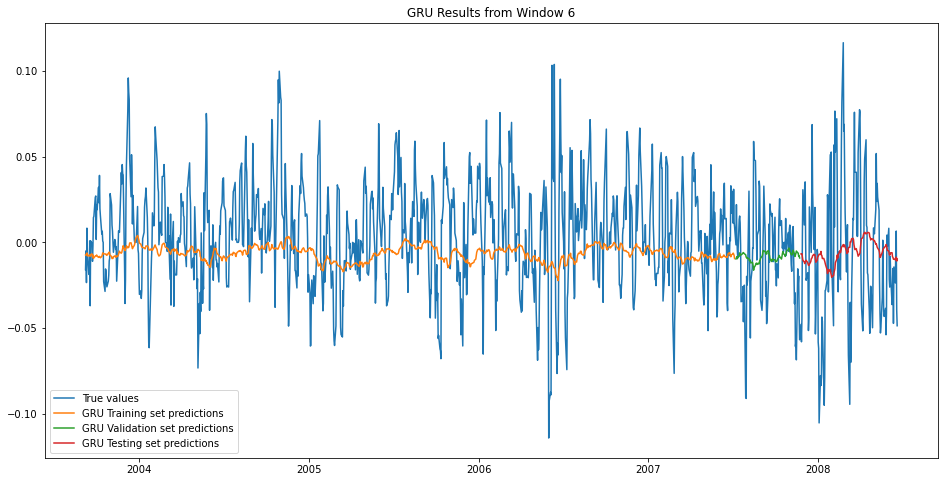

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0014045780826066508
RMSE = 0.03747770113823219
MAE = 0.030022400812900522
R-Squared = -0.4179427355529015

Results on Validation set: 
MSE = 0.0016125440585542782
RMSE = 0.040156494599930884
MAE = 0.033075509556677235
R-Squared = 0.0567208403766829

Results on Testing set: 
MSE = 0.0026057782868887645
RMSE = 0.051046824454502204
MAE = 0.04219764501546132
R-Squared = 0.05748970596362568



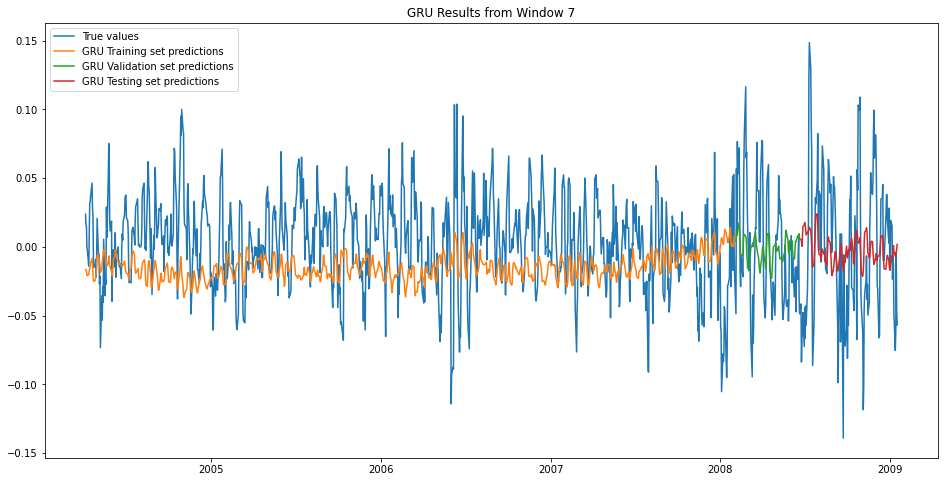

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0014165742417300978
RMSE = 0.03763740482193343
MAE = 0.02988650367257371
R-Squared = -0.19057188400400782

Results on Validation set: 
MSE = 0.0026421143251723163
RMSE = 0.051401501195707466
MAE = 0.04201269092524071
R-Squared = -0.056711875426061376

Results on Testing set: 
MSE = 0.0021462356820646433
RMSE = 0.046327483010246126
MAE = 0.035117111386781266
R-Squared = -0.11466064324490088



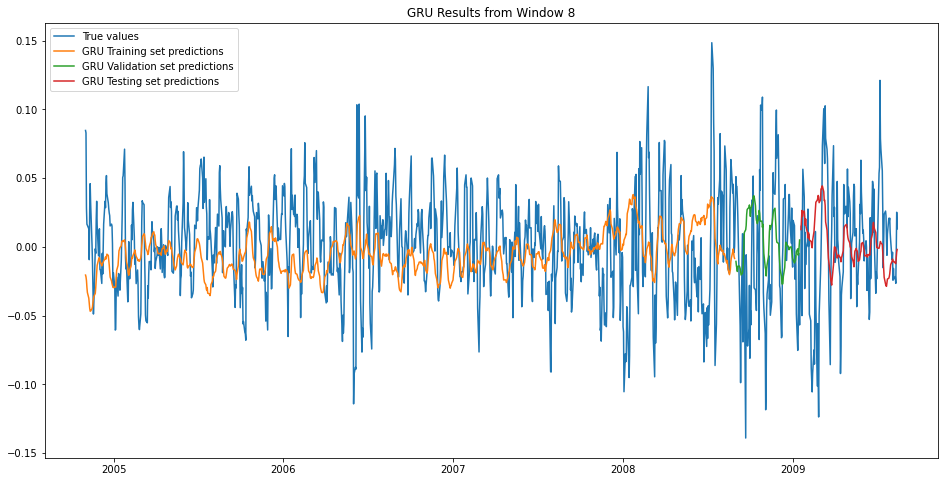

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0016506293374287
RMSE = 0.04062793789289213
MAE = 0.031472288428687156
R-Squared = -0.0992743206150295

Results on Validation set: 
MSE = 0.0010512185465174722
RMSE = 0.032422500620980364
MAE = 0.02502122468207625
R-Squared = 0.03833376946834055

Results on Testing set: 
MSE = 0.0006175819402259708
RMSE = 0.02485119595162315
MAE = 0.019957687461007675
R-Squared = -0.11104778797970405



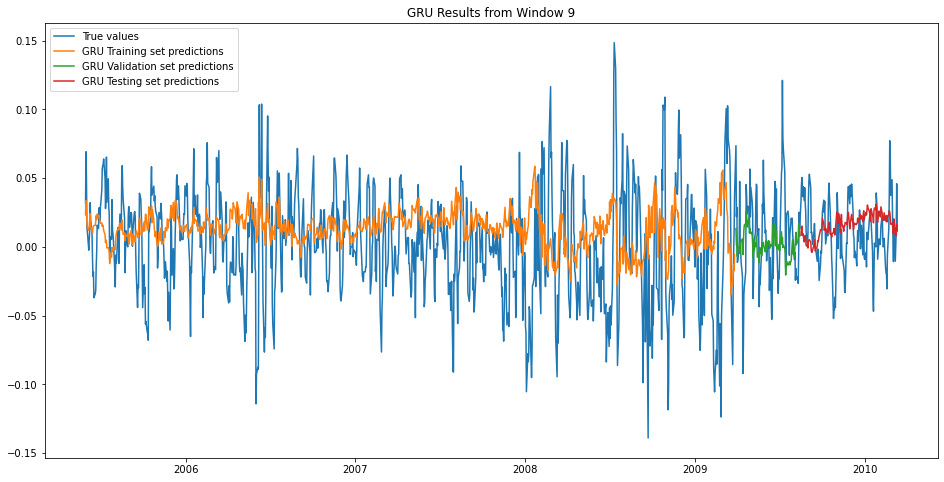

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0015259208703766835
RMSE = 0.03906303713712854
MAE = 0.029792832030033613
R-Squared = -0.012697622443622825

Results on Validation set: 
MSE = 0.00047355190306974134
RMSE = 0.021761247736969067
MAE = 0.01632520948379618
R-Squared = 0.22291221660409766

Results on Testing set: 
MSE = 0.0009219257642426554
RMSE = 0.030363230464538114
MAE = 0.02448579182932914
R-Squared = 0.01237157033205527



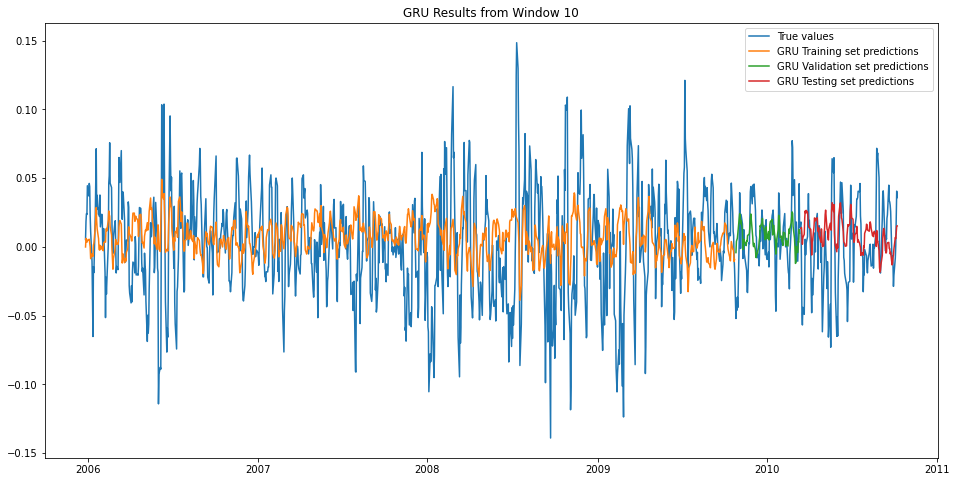

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0017389609227492198
RMSE = 0.041700850384005596
MAE = 0.031170428383394386
R-Squared = -0.25028787933055696

Results on Validation set: 
MSE = 0.0007889730167700322
RMSE = 0.028088663492057294
MAE = 0.02331129853219021
R-Squared = 0.09052474077108241

Results on Testing set: 
MSE = 0.000696752302735632
RMSE = 0.02639606604658414
MAE = 0.01858321510139198
R-Squared = -0.342589417153218



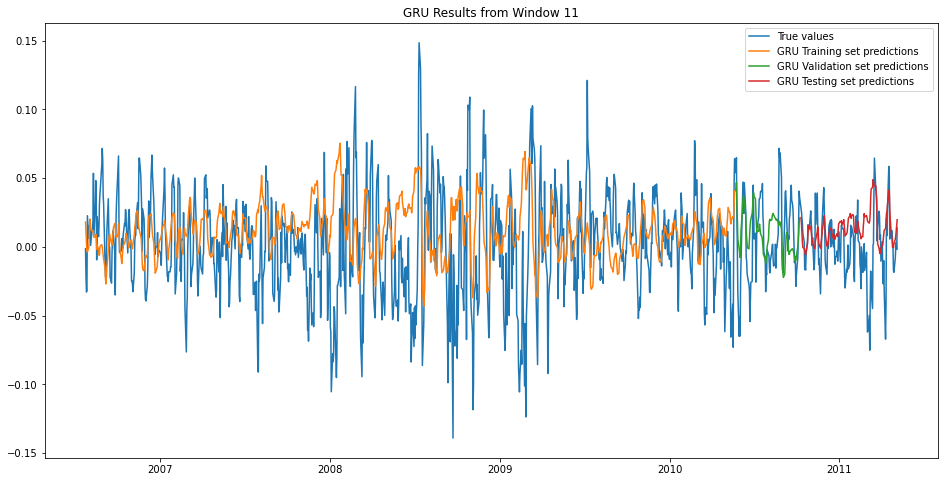

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0013038273688756987
RMSE = 0.036108549802999546
MAE = 0.02724308181067424
R-Squared = 0.052662799278373584

Results on Validation set: 
MSE = 0.0006422924887914658
RMSE = 0.025343490067302604
MAE = 0.017773024265335367
R-Squared = -0.056665134531560524

Results on Testing set: 
MSE = 0.001333933128901281
RMSE = 0.0365230492826281
MAE = 0.02880563155728701
R-Squared = 0.013538448110840484



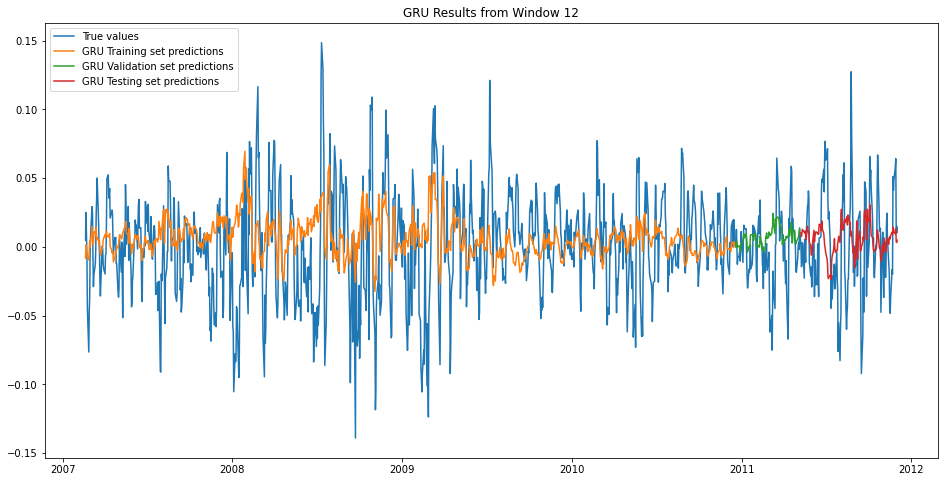

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0018185265058454805
RMSE = 0.04264418490070458
MAE = 0.03216522618261505
R-Squared = -0.3223522866501074

Results on Validation set: 
MSE = 0.0012014163029973944
RMSE = 0.034661452696005034
MAE = 0.02709340206825176
R-Squared = 0.19259365485216962

Results on Testing set: 
MSE = 0.0005230923532450527
RMSE = 0.02287121232565193
MAE = 0.018619677967293653
R-Squared = -0.32444047164263035



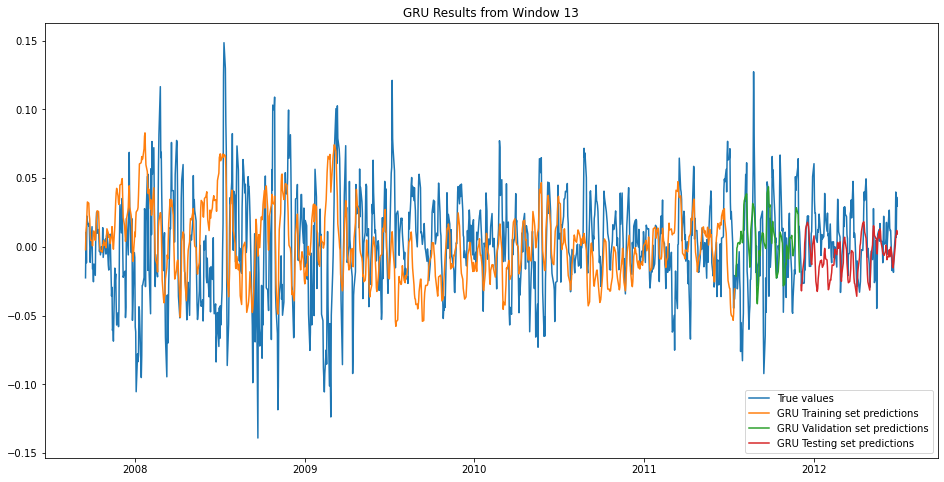

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0014582858810391443
RMSE = 0.03818750948987305
MAE = 0.028737606269245472
R-Squared = -0.12866728986461995

Results on Validation set: 
MSE = 0.0003191104594548991
RMSE = 0.01786366310292766
MAE = 0.013923494352570733
R-Squared = 0.21345984191727863

Results on Testing set: 
MSE = 0.0005447976237410272
RMSE = 0.023340900234160362
MAE = 0.01726069158287362
R-Squared = -0.089934798420779



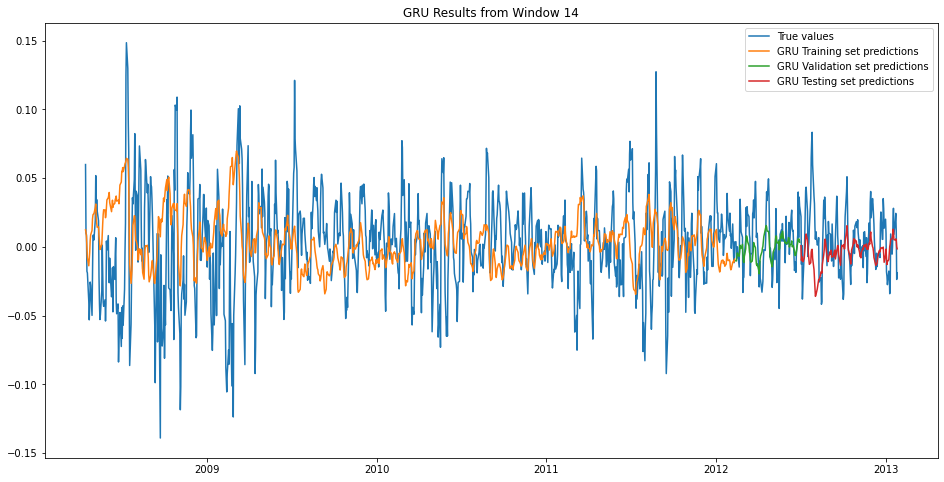

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0009445639338876515
RMSE = 0.030733758863628308
MAE = 0.022862424793400137
R-Squared = 0.04278559220025058

Results on Validation set: 
MSE = 0.00026747979933365216
RMSE = 0.016354809669747068
MAE = 0.013173252039700725
R-Squared = 0.24800919899169083

Results on Testing set: 
MSE = 0.0014112725290220433
RMSE = 0.03756690736568614
MAE = 0.029071363625694808
R-Squared = -0.15545741991469852



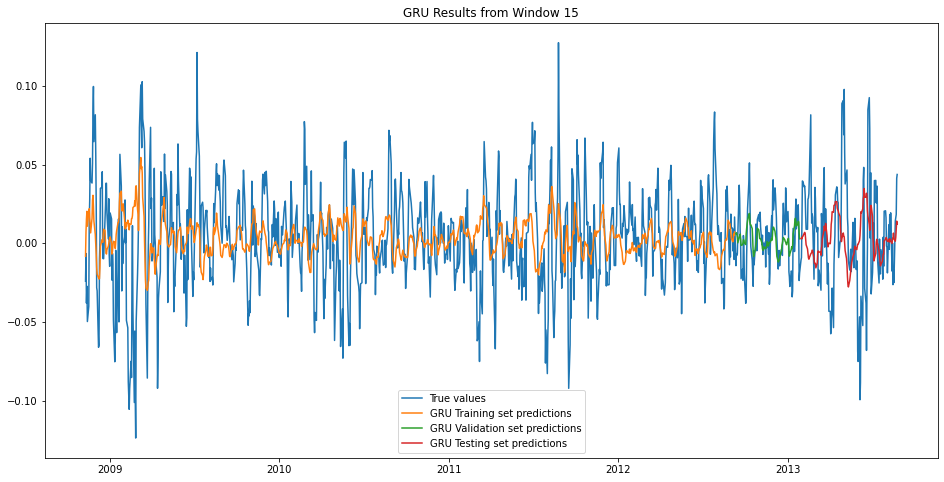

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0007137046503277951
RMSE = 0.026715251268288588
MAE = 0.02051987159780858
R-Squared = 0.044617361602372174

Results on Validation set: 
MSE = 0.001319414002096799
RMSE = 0.03632373882321035
MAE = 0.027233643178660897
R-Squared = 0.05142435114069566

Results on Testing set: 
MSE = 0.0006701213861235009
RMSE = 0.025886702882435626
MAE = 0.01933530452331235
R-Squared = -0.04795599163405373



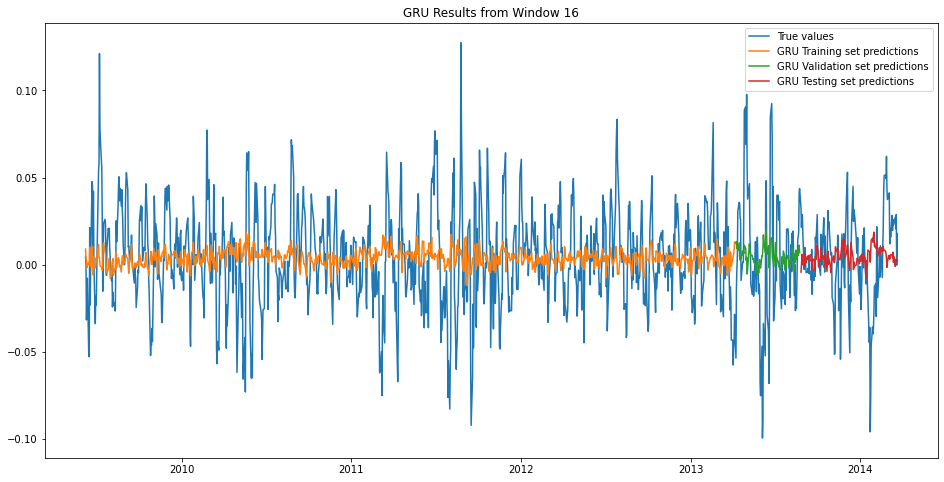

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0006880062057994685
RMSE = 0.026229872393884582
MAE = 0.020194692344177718
R-Squared = 0.11838647600500996

Results on Validation set: 
MSE = 0.0008064034513027525
RMSE = 0.028397243727213254
MAE = 0.02202068618604784
R-Squared = 0.07399215015450944

Results on Testing set: 
MSE = 0.0003599628204974725
RMSE = 0.018972686169793473
MAE = 0.014906604359068813
R-Squared = -0.12112866663890198



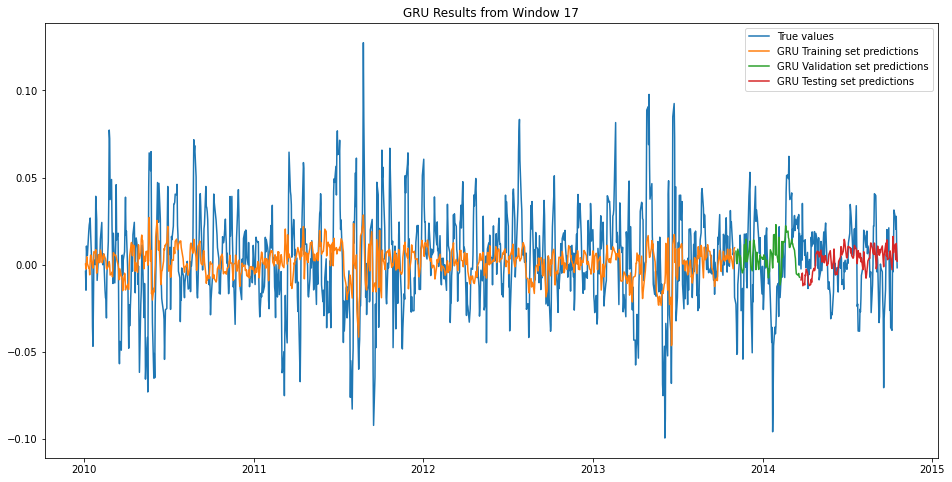

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0006866772513789414
RMSE = 0.02620452730691667
MAE = 0.019774206475132217
R-Squared = 0.07371741331151971

Results on Validation set: 
MSE = 0.00035760804948576323
RMSE = 0.01891052747772423
MAE = 0.014775495714766808
R-Squared = 0.05280378665264218

Results on Testing set: 
MSE = 0.0008920394186568929
RMSE = 0.029867028955972385
MAE = 0.022685301589461797
R-Squared = 0.02761397095410789



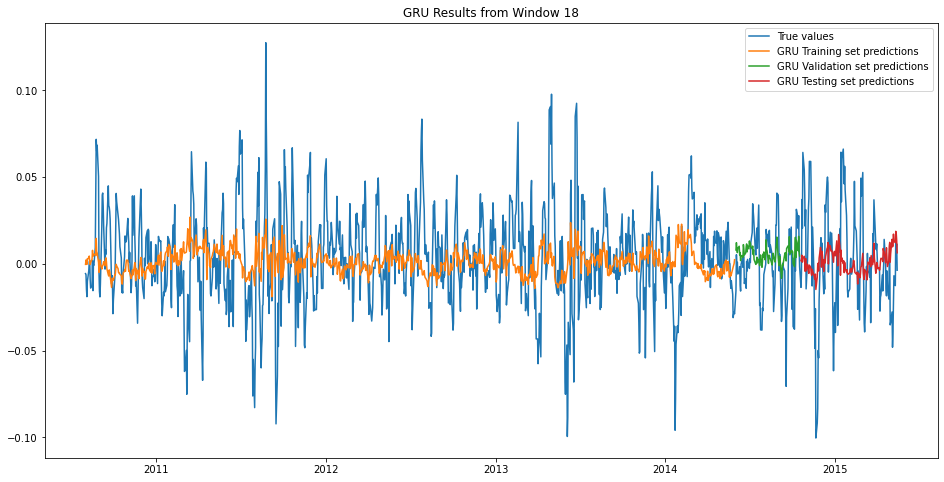

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0007216941911782318
RMSE = 0.02686436656945836
MAE = 0.020580668579371932
R-Squared = 0.08545546244224755

Results on Validation set: 
MSE = 0.0006947767001096565
RMSE = 0.026358617188874996
MAE = 0.019987994986858645
R-Squared = -0.03431455574387021

Results on Testing set: 
MSE = 0.0009274490726370236
RMSE = 0.030454048542632613
MAE = 0.023966273037742635
R-Squared = -0.07939628287533984



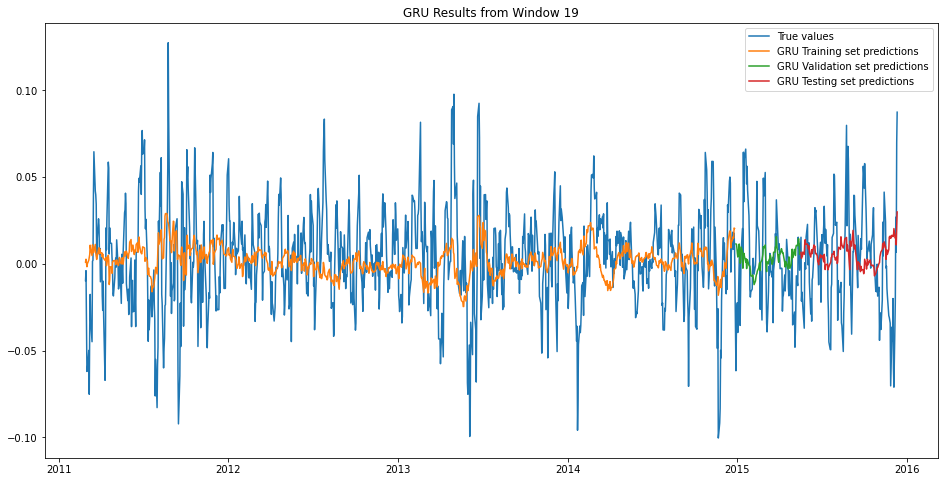

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0006168856421032394
RMSE = 0.024837182652290485
MAE = 0.018511521604372836
R-Squared = 0.08596532987124417

Results on Validation set: 
MSE = 0.0010206545051440624
RMSE = 0.031947683877615644
MAE = 0.024909906772534685
R-Squared = 0.026885115230714907

Results on Testing set: 
MSE = 0.003977962452321427
RMSE = 0.06307109046402659
MAE = 0.039763849240358196
R-Squared = -0.1820892138047394



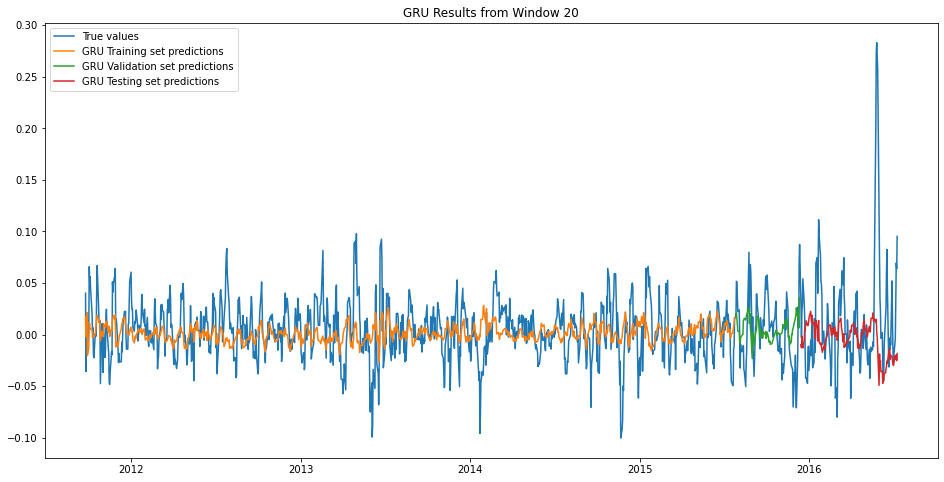

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0007127789305481085
RMSE = 0.026697919966696067
MAE = 0.019846851831306283
R-Squared = 0.06590134327870978

Results on Validation set: 
MSE = 0.0045474053884374446
RMSE = 0.06743445253308908
MAE = 0.0390836951172088
R-Squared = -0.06115206331399503

Results on Testing set: 
MSE = 0.001236824766800552
RMSE = 0.03516851954234855
MAE = 0.02818258658321075
R-Squared = 0.000733310851805502



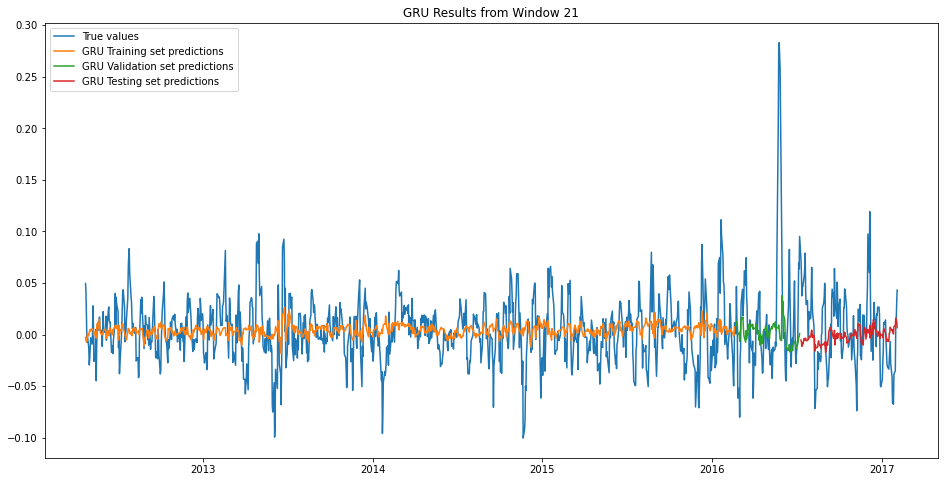

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0011870215616384043
RMSE = 0.03445317926749873
MAE = 0.023877770883893097
R-Squared = 0.021296322800728684

Results on Validation set: 
MSE = 0.0010637470290755834
RMSE = 0.032615134969452196
MAE = 0.025257283540679888
R-Squared = 0.021605150453804955

Results on Testing set: 
MSE = 0.0009833097286420967
RMSE = 0.031357769828897215
MAE = 0.02568928885191769
R-Squared = 0.006368570469044377



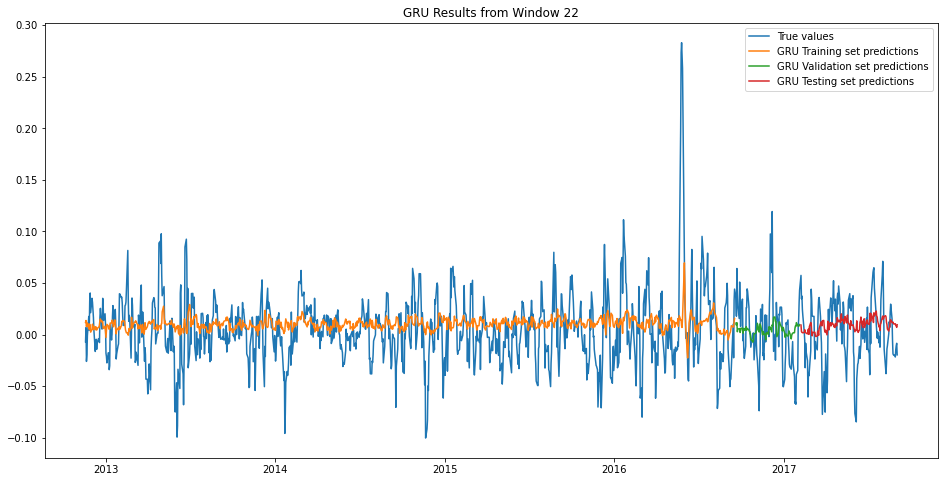

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0011577388854811083
RMSE = 0.0340255622360764
MAE = 0.02348523339790976
R-Squared = 0.05560738234279183

Results on Validation set: 
MSE = 0.0007518628741381739
RMSE = 0.027420118054781856
MAE = 0.022147046260263457
R-Squared = 0.17343029653389586

Results on Testing set: 
MSE = 0.002062054566096756
RMSE = 0.04540985098078121
MAE = 0.03426394899046205
R-Squared = -0.19535193107153348



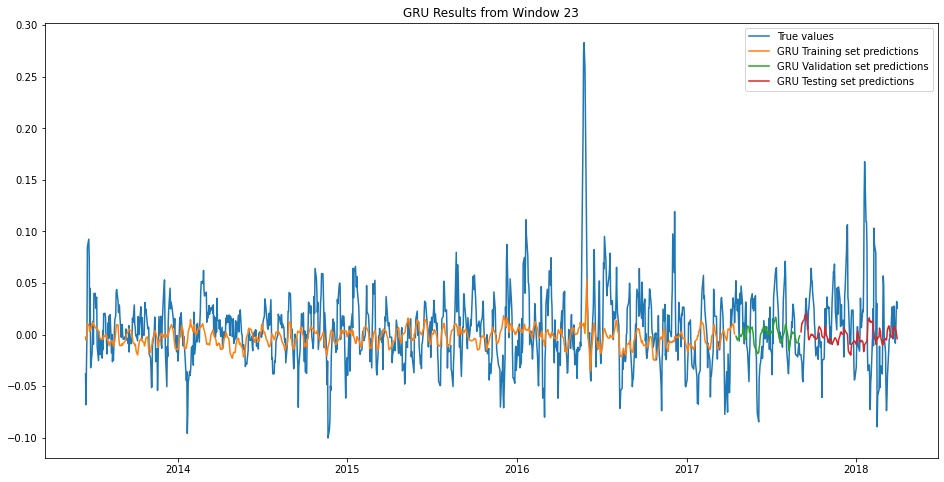

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0011776133176861392
RMSE = 0.034316370986544296
MAE = 0.024551565082853735
R-Squared = 0.06939141691584194

Results on Validation set: 
MSE = 0.0023498949792383154
RMSE = 0.04847571535561198
MAE = 0.036428802627018364
R-Squared = -0.06984245434155945

Results on Testing set: 
MSE = 0.0021321218964713683
RMSE = 0.0461749054841628
MAE = 0.03759516618006312
R-Squared = -0.4287910706931015



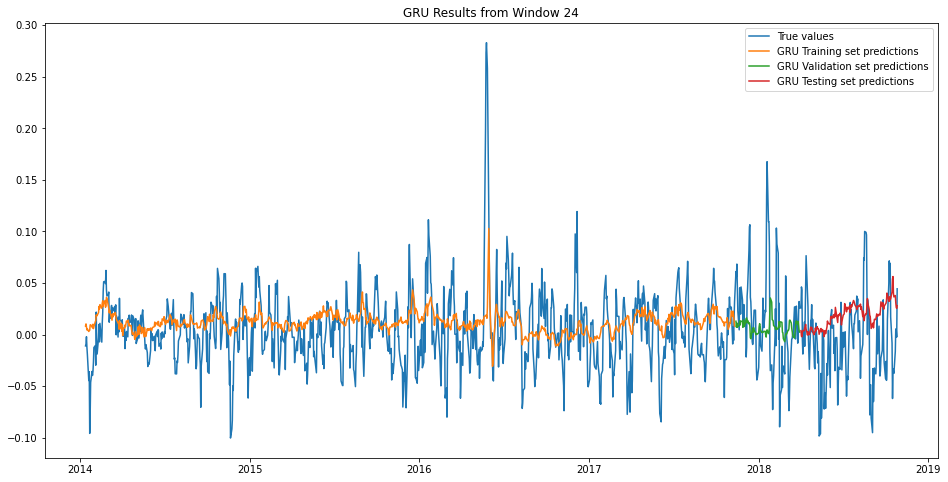

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4849

Results on Training set: 
MSE = 0.0015966113619077116
RMSE = 0.03995761957258855
MAE = 0.028450703115800457
R-Squared = -0.0675576560814255

Results on Validation set: 
MSE = 0.0014977881607916872
RMSE = 0.038701268206503096
MAE = 0.03008076067539327
R-Squared = 0.0054811194012803766

Results on Testing set: 
MSE = 0.0012644633908926043
RMSE = 0.03555929401566634
MAE = 0.02801591074039375
R-Squared = -0.06782815318570634



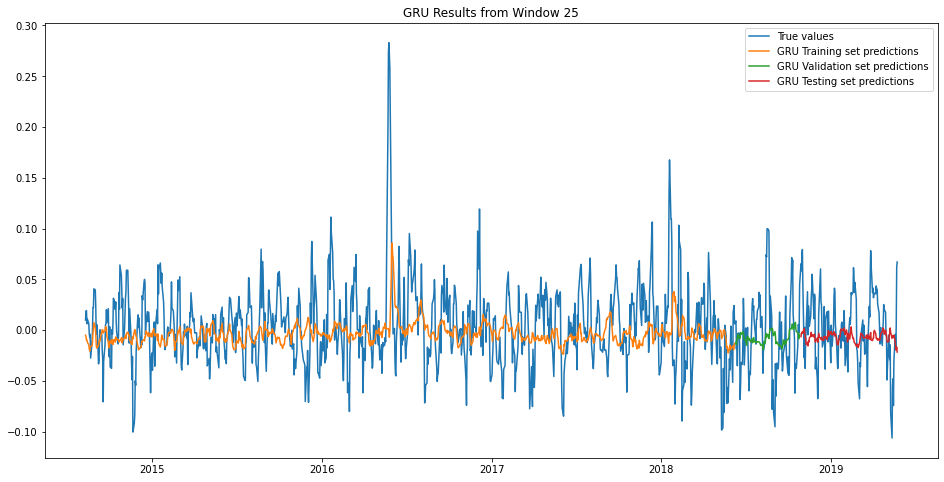

Window 26: 
Training datapoints: 3750 - 4749
Validation datapoints: 4750 - 4849
Testing datapoints: 4850 - 5001

Results on Training set: 
MSE = 0.0015650489455677299
RMSE = 0.03956069950806899
MAE = 0.028327124415105535
R-Squared = 0.0018069714827620986

Results on Validation set: 
MSE = 0.001043330539234902
RMSE = 0.03230062753623994
MAE = 0.025674074583353187
R-Squared = 0.12644505013702534

Results on Testing set: 
MSE = 0.0013543835491795252
RMSE = 0.03680195034477827
MAE = 0.029635376961447
R-Squared = 0.06077397250124905



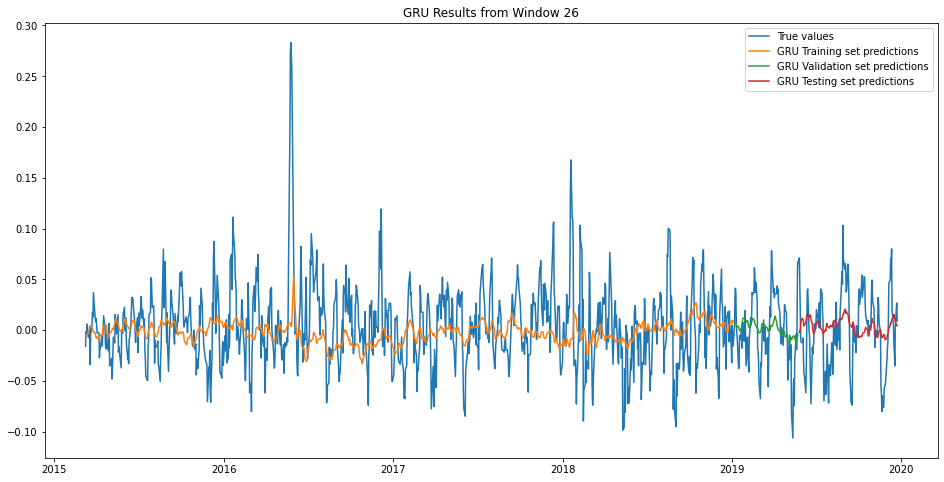

In [10]:
#Declaring model parameters
sequencelength = 117
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.001278618789732958
RMSE = 0.03575777942955852
MAE = 0.026693952538739137
R-Squared = -0.062330026515934556

GRU model results on the Testing set
MSE = 0.001327216122182449
RMSE = 0.0364309775079183
MAE = 0.027278300158058183
R-Squared = -0.10324916093616987

Naive model results on the Testing set
MSE = 0.0025486893021816133
RMSE = 0.05048454518148711
MAE = 0.03830514368225681
R-Squared = -1.1193063238520011

Drift model results on the Testing set
MSE = 0.0031159963372527277
RMSE = 0.05582111013991685
MAE = 0.04209965879102654
R-Squared = -1.5910379648812962



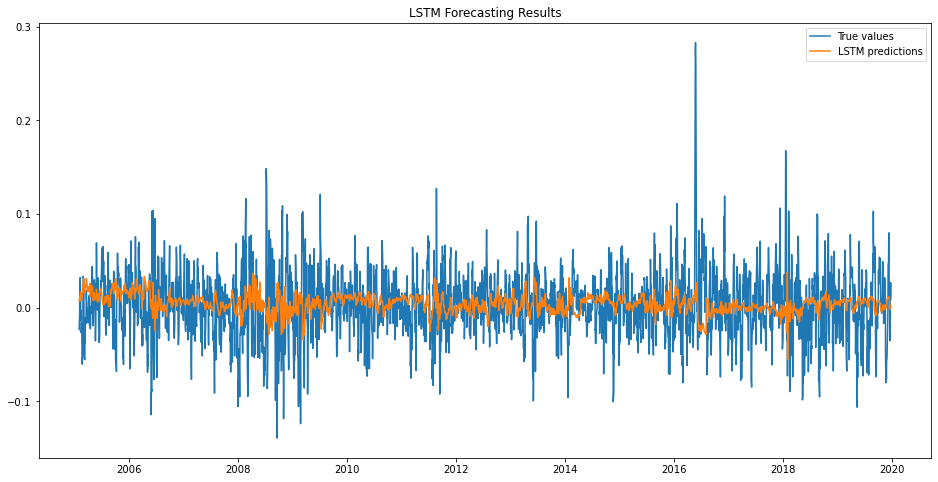

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

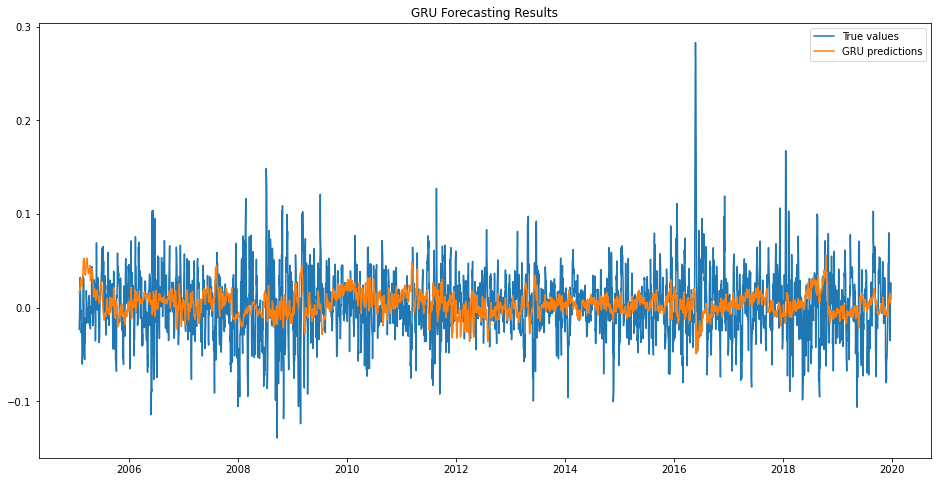

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

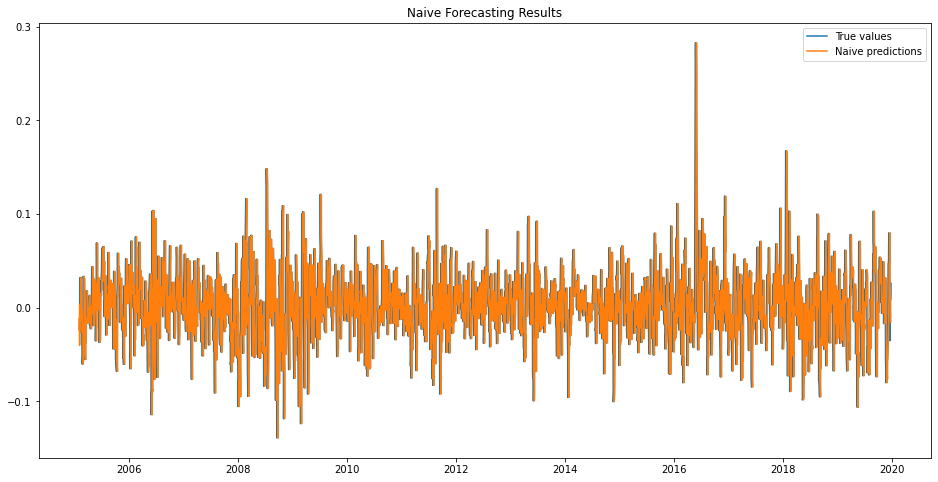

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

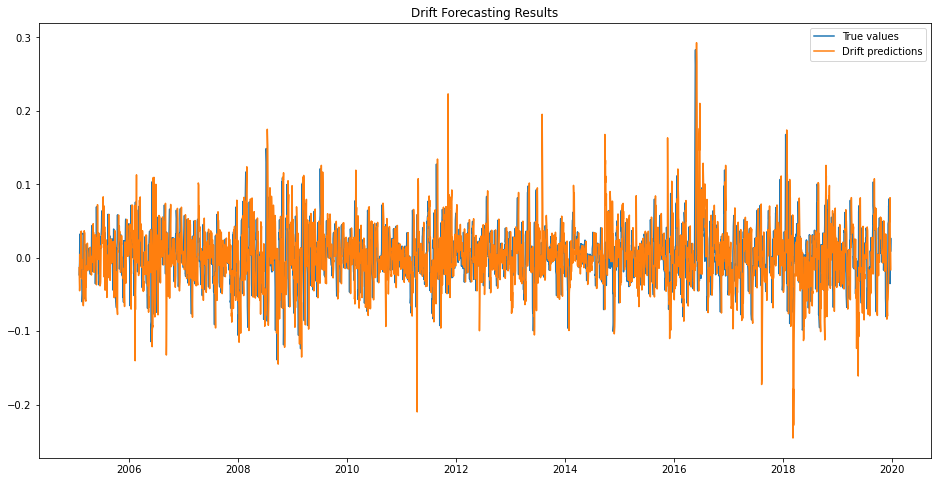

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['BVT LSTM'] = lstm_predictions[-numpreds:]
savePredictions['BVT GRU'] = gru_predictions[-numpreds:]
savePredictions['BVT Naive'] = naive_predictions[-numpreds:]
savePredictions['BVT Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./BVT_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

BVT LSTM   BVT GRU  BVT Naive  BVT Drift
Date                                                
2005-02-04  0.007233  0.016009  -0.012326  -0.013577
2005-02-07  0.009200  0.018581  -0.040005  -0.044963
2005-02-08  0.011393  0.020193  -0.035594  -0.039841
2005-02-09  0.007246  0.019322   0.003759   0.004667
2005-02-10  0.007879  0.021915  -0.017782  -0.019590